# Covariance modeling for kernels

---

Comparisons in 5.1.3 suggest that the covariance modeling (but not the kernel simplification) could be the potential cause of inferior fits of kernel-based approach.

In this notebook, we aim to use the formulations in 3.2.3, and extend the idea to also fit a covariance structure for the highest colinear kernel pairs.


### package imports and basic functions

---

In [1]:
import os
import gc
import sys
import glob
import json
import random
import datetime
import importlib
import itertools
import numpy as np
from scipy import spatial
import scipy.sparse as sparse
import scipy.stats as stats
import pandas as pd
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import boto3


In [2]:
# pymc libraries
import pymc as pm
import arviz as az
import xarray as xr
import patsy

print(f"Running on PyMC v{pm.__version__}")


Running on PyMC v4.2.2


In [3]:
class MyNumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)


def ensure_dir(file_name):
    os.makedirs(os.path.dirname(file_name), exist_ok=True)
    return file_name


def list_dirs(path=os.getcwd()):
    files = glob.glob(os.path.join(path, '*'))
    files = [x for x in files if os.path.isdir(x)]
    return files


def file_exists(file_name, path_name=os.getcwd()):
    return os.path.isfile(os.path.join(path_name, file_name))


def write_json(json_obj, file_path):
    with open(file_path, 'w') as outfile:
        json.dump(json_obj, outfile, sort_keys=True, indent=4,
                  cls=MyNumpyEncoder)
    return json_obj


def load_json(file_path):
    with open(file_path, 'r') as infile:
        return json.load(infile)


def write_np(np_obj, file_path):
    with open(file_path, 'wb') as outfile:
        np.save(outfile, np_obj)


def load_np(file_path):
    with open(file_path, 'rb') as infile:
        return np.load(infile)


In [4]:
# path setting
main_dir = os.path.abspath('../../../..')
main_dir


'/mountpoint/code/projects/normative_brain_charts'

### Brain visualization functions

---

In [5]:
from nilearn import datasets, surface, plotting
from matplotlib.colors import LinearSegmentedColormap


In [6]:
# basic parameters
surface = 'inflated_MSMAll'
expand = 0

# load an example dscalar
dscalar_file = f'{main_dir}/data/templates/ones.dscalar.nii'
dscalar = nib.load(dscalar_file)

brain_models = [x for x in dscalar.header.get_index_map(1).brain_models]

# load surfaces for visualization
left_surface_file = f'{main_dir}/data/templates/hcp_surf/S1200.L.{surface}.32k_fs_LR.surf.gii'
left_surface = nib.load(left_surface_file)
right_surface_file = f'{main_dir}/data/templates/hcp_surf/S1200.R.{surface}.32k_fs_LR.surf.gii'
right_surface = nib.load(right_surface_file)

# extract surface information
lx, ly, lz = left_surface.darrays[0].data.T
lt = left_surface.darrays[1].data
rx, ry, rz = right_surface.darrays[0].data.T
rt = right_surface.darrays[1].data

# combine into a complete brain
lrx = np.concatenate([lx - expand, rx + expand])
lry = np.concatenate([ly, ry])
lrz = np.concatenate([lz, rz])
lrt = np.concatenate([lt, (rt + lx.shape[0])])

lxyz = left_surface.darrays[0].data
rxyz = right_surface.darrays[0].data
lrxyz = np.array([lrx, lry, lrz]).T

# create a mapping between surface and cifti vertices
left_cortical_surface_model, right_cortical_surface_model = brain_models[0], brain_models[1]
cifti_to_surface = {}
surface_to_cifti = {}
for (i, x) in enumerate(left_cortical_surface_model.vertex_indices):
    cifti_to_surface[i] = x
    surface_to_cifti[x] = i
for (i, x) in enumerate(right_cortical_surface_model.vertex_indices):
    cifti_to_surface[i + right_cortical_surface_model.index_offset] = x + rx.shape[0]
    surface_to_cifti[x + rx.shape[0]] = i + right_cortical_surface_model.index_offset

# construct data over surface
surface_mask = list(surface_to_cifti.keys())


In [7]:
# arbitrary colormap
mycm = LinearSegmentedColormap.from_list(
    'my_gradient',
    (
        (0.0, (0.1, 0.1, 1.,)),
        # (0.4999, (0.9, 0.9, 1.,)),
        (0.25, (0.1, 1., 1.,)),
        # (0.4999, (0.9, 1., 1.,)),
        (0.5, (1., 1., 1.,)),
        # (0.5001, (1., 1., 0.9,)),
        (0.75, (1., 1., 0.1,)),
        # (0.5001, (1., 0.9, 0.9,)),
        (1.0, (1., 0.1, 0.1,)),
    )
)

mycm_dark = LinearSegmentedColormap.from_list(
    'my_gradient',
    (
        (0.0, (0.05, 1., 1.,)),
        (0.35, (0.05, 0.05, 1.,)),
        (0.5, (0.2, 0.05, 0.05,)),
        (0.65, (1., 0.05, 0.05,)),
        (1.0, (1., 1., 0.05,)),
    )
)

# ignore warning when loading cifti
nib.imageglobals.logger.setLevel(40)

# load sulcal depth for background
sulcal_depth = nib.load(f"{main_dir}/data/templates/hcp_surf/S1200.sulc_MSMAll.32k_fs_LR.dscalar.nii")


# visualization via nilearn
def plot_data_on_brain_surface(data, title="", cmap=mycm, symmetric_cbar=True, vmax=None, vmin=None, background_data=sulcal_depth.get_fdata()[0], darkness=0.1, auto_vlim_quantile=0.05, colorbar_format=None):
    """
    Plot a cifti-like data over the fs-LR32k surface space.
    ----------------------------------------------------------------
    Parameters:
        - data: a vector of shape (59412,) to be visualized.
        - title: the title of generated plot.
        - cmap: the colormap used for the plot.
        - symmetric_cbar: bool, Specifies whether the 
          colorbar should be symmetric (centered at zero).
        - vmax: colorbar max limit.
        - vmin: colorbar min limit.
        - background data: a surface data to project as a shadow
          behind the main data. (use None for no background)
        - darkness: the background effect
        - auto_vlim_quantile: the quantile to define vmin and vmax
          automatically (should be in the range of [0,0.5)]).
        - colorbar_format: string format for numbers in colorbar.
    ----------------------------------------------------------------
    """
    # Initialization
    if vmax is None:
        vmax = np.quantile(data,1 - auto_vlim_quantile)
    if vmin is None:
        vmin = np.quantile(data,auto_vlim_quantile)
    if symmetric_cbar:
        (vmin, vmax) = -max(abs(vmin), abs(vmax)), max(abs(vmin), abs(vmax))
    if background_data is not None:
        background = True
    else:
        background = False
    
    # surface center
    cxyz=(lrxyz.min(0) + lrxyz.max(0))/2

    # transfer data to surface scalar
    surface_scalars = np.empty(lrx.shape[0])
    surface_scalars[:] = np.nan
    surface_scalars[surface_mask] = data.copy()

    # decompose left and right information
    left_surface_scalars = surface_scalars[:lx.shape[0]]
    right_surface_scalars = surface_scalars[-rx.shape[0]:]
    
    # Generate background data
    surface_background_data = np.zeros(lrx.shape[0])
    surface_background_data[surface_mask] = background_data.copy()
    left_background_data = surface_background_data[:lx.shape[0]]
    right_background_data = surface_background_data[-rx.shape[0]:]


    fig, axes = plt.subplots(2, 2, figsize=(8, 8), subplot_kw={'projection': '3d'});

    zoom_coeff = 0.85

    # 'lateral', 'medial', 'dorsal', 'ventral', 'anterior', 'posterior'
    plotting.plot_surf(
        [lxyz-cxyz, lt],
        left_surface_scalars,
        axes=axes[0,0],
        view='lateral',
        colorbar=False,
        symmetric_cbar=False,
        darkness=darkness,
        vmax=vmax,
        vmin=vmin,
        cmap=cmap,
        bg_on_data=background,
        bg_map=left_background_data,
    );
    axes[0,0].set_xlim3d(np.array(axes[0,0].get_xlim3d())*zoom_coeff)
    axes[0,0].set_ylim3d(np.array(axes[0,0].get_ylim3d())*zoom_coeff)
    axes[0,0].set_zlim3d(np.array(axes[0,0].get_zlim3d())*zoom_coeff)

    plotting.plot_surf(
        [rxyz-cxyz, rt],
        right_surface_scalars,
        axes=axes[0,1],
        view='medial',
        colorbar=False,
        symmetric_cbar=False,
        darkness=darkness,
        vmax=vmax,
        vmin=vmin,
        cmap=cmap,
        bg_on_data=background,
        bg_map=right_background_data,
    );
    axes[0,1].set_xlim3d(np.array(axes[0,1].get_xlim3d())*zoom_coeff)
    axes[0,1].set_ylim3d(np.array(axes[0,1].get_ylim3d())*zoom_coeff)
    axes[0,1].set_zlim3d(np.array(axes[0,1].get_zlim3d())*zoom_coeff)


    plotting.plot_surf(
        [lxyz-cxyz, lt],
        left_surface_scalars,
        axes=axes[1,0],
        view='medial',
        colorbar=False,
        symmetric_cbar=False,
        darkness=darkness,
        vmax=vmax,
        vmin=vmin,
        cmap=cmap,
        bg_on_data=background,
        bg_map=left_background_data,
    );
    axes[1,0].set_xlim3d(np.array(axes[1,0].get_xlim3d())*zoom_coeff)
    axes[1,0].set_ylim3d(np.array(axes[1,0].get_ylim3d())*zoom_coeff)
    axes[1,0].set_zlim3d(np.array(axes[1,0].get_zlim3d())*zoom_coeff)

    plotting.plot_surf(
        [rxyz-cxyz, rt],
        right_surface_scalars,
        axes=axes[1,1],
        view='lateral',
        colorbar=False,
        symmetric_cbar=False,
        darkness=darkness,
        vmax=vmax,
        vmin=vmin,
        cmap=cmap,
        bg_on_data=background,
        bg_map=right_background_data,
    );
    axes[1,1].set_xlim3d(np.array(axes[1,1].get_xlim3d())*zoom_coeff)
    axes[1,1].set_ylim3d(np.array(axes[1,1].get_ylim3d())*zoom_coeff)
    axes[1,1].set_zlim3d(np.array(axes[1,1].get_zlim3d())*zoom_coeff)

    fig.suptitle(title, fontsize=24, y=0.98);
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=-0., hspace=-0.25)

    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    axins = inset_axes(
        axes[0,0],
        width="30%",
        height="4%",
        loc="center",
        bbox_to_anchor=(-0., 0.02, 1., 1.),
        bbox_transform=fig.transFigure,
        borderpad=0,
    )
    cb = fig.colorbar(
        mpl.cm.ScalarMappable(
            norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax),
            cmap=cmap
        ),
        cax=axins,
        aspect=10,
        orientation='horizontal',
        format=colorbar_format,
    )
    cb.outline.set_visible(False)
    cb.ax.tick_params(labelsize=12)
    cb.ax.tick_params(length=0)


## Load aggregated data

---

In [8]:
demography_df = pd.read_csv(f'{main_dir}/data/csv/demography_all_datasets.csv', index_col=0).reset_index(drop=True)
demography_df.head()


age  thickness  sex     subject_ID dataset           site  siteCode
0  32.0   2.636395  1.0  HCP-YA-130518  HCP-YA  HCP-YA-site_0         0
1  35.0   2.633850  1.0  HCP-YA-192237  HCP-YA  HCP-YA-site_0         0
2  31.0   2.704905  1.0  HCP-YA-859671  HCP-YA  HCP-YA-site_0         0
3  33.0   2.629196  0.0  HCP-YA-158136  HCP-YA  HCP-YA-site_0         0
4  22.0   2.760889  0.0  HCP-YA-192136  HCP-YA  HCP-YA-site_0         0

## Load high-resolution thickness data

---

In [9]:
all_thickness_data = load_np(f'{main_dir}/data/npy/thickness_all_datasets.npy');
all_thickness_data.shape


(2473, 59412)

## Load the CSS kernel

---

In [10]:
# load the stored kernel
fwhm = 5
css_kernel_eigenvalues = load_np(f'{main_dir}/data/npy/css_kernel_eigenvalues_{fwhm}mmFWHM.npy');
css_kernel_eigenvectors = load_np(f'{main_dir}/data/npy/css_kernel_eigenvectors_{fwhm}mmFWHM.npy');


## Encode the high-resolution data by kernel and attach to the demography data

---

In [11]:
# center the data prior to encoding
all_thickness_data_encoded = np.dot(all_thickness_data, css_kernel_eigenvectors)
all_thickness_data_encoded.shape


(2473, 2001)

In [12]:
demography_extended_df = pd.concat(
    [
        demography_df,
        pd.DataFrame(
            all_thickness_data_encoded,
            columns=[f'thickness_css_{i}' for i in range(all_thickness_data_encoded.shape[1])],
        ),
    ],
    axis=1,
)

demography_extended_df.head()


age  thickness  sex     subject_ID dataset           site  siteCode  \
0  32.0   2.636395  1.0  HCP-YA-130518  HCP-YA  HCP-YA-site_0         0   
1  35.0   2.633850  1.0  HCP-YA-192237  HCP-YA  HCP-YA-site_0         0   
2  31.0   2.704905  1.0  HCP-YA-859671  HCP-YA  HCP-YA-site_0         0   
3  33.0   2.629196  0.0  HCP-YA-158136  HCP-YA  HCP-YA-site_0         0   
4  22.0   2.760889  0.0  HCP-YA-192136  HCP-YA  HCP-YA-site_0         0   

   thickness_css_0  thickness_css_1  thickness_css_2  ...  thickness_css_1991  \
0       540.848068       328.405088       -58.875203  ...           -2.989428   
1       543.507714       323.441478       -50.223979  ...           -2.861579   
2       557.540900       334.750308       -47.242142  ...           -1.953069   
3       541.266533       324.140321       -55.719439  ...           -0.562489   
4       568.037553       342.473082       -61.126235  ...           -0.157777   

   thickness_css_1992  thickness_css_1993  thickness_css_1994  \
0           -0.068005            3.195871           -0.486385   
1            0.173527            0.470815            0.335621   
2            1.547393            1.052983           -0.282225   
3            0.933322            0.347921            1.346396   
4            1.118155            0.281123           -0.601192   

   thickness_css_1995  thickness_css_1996  thickness_css_1997  \
0            1.388692            0.790643           -1.385377   
1            1.752842           -1.659001           -0.929015   
2           -0.662044           -0.657760           -1.773588   
3           -1.391554           -0.904728           -0.204043   
4            0.991797           -0.982564           -0.976174   

   thickness_css_1998  thickness_css_1999  thickness_css_2000  
0           -0.132055            0.294909            1.125785  
1           -1.196669            0.499736           -0.200770  
2           -1.853987           -0.479072           -1.234758  
3            0.522450           -0.127720            1.778896  
4            1.511172           -0.405743            0.693013  

[5 rows x 2008 columns]

## Select largest covariance pairs

---

The largest pairs of kernels in terms of correlation could be used to model a sparse covariance structure.

In [13]:
# Estimate covariance matrix
covariances = np.cov(all_thickness_data_encoded.T)
correlations = np.corrcoef(all_thickness_data_encoded.T)
covariances.shape


(2001, 2001)

In [14]:
pd.unique(demography_df['siteCode'])

array([0, 1, 2])

In [15]:
all_thickness_data_encoded.shape

(2473, 2001)

In [16]:
# Estimate covariance matrix over different subsets of sample
cov_dict = {}

for siteCode in pd.unique(demography_df['siteCode']):
    for sex in pd.unique(demography_df['sex']):
        subset_site = (demography_df['siteCode'] == siteCode)
        subset_sex = (demography_df['sex'] == sex)
        cov_dict[f'siteCode-{siteCode}'] = np.cov(all_thickness_data_encoded[subset_site].T)
        cov_dict[f'sex-{sex}'] = np.cov(all_thickness_data_encoded[subset_sex].T)
        cov_dict[f'siteCode-{siteCode}&sex-{sex}'] = np.cov(all_thickness_data_encoded[subset_site & subset_sex].T)

cov_max_site_sex = np.maximum.reduce([cov_dict[x] for x in cov_dict.keys()])
cov_max_site_sex.shape


(2001, 2001)

In [17]:
# Estimate correlation matrix over different subsets of sample
corr_dict = {}

for siteCode in pd.unique(demography_df['siteCode']):
    for sex in pd.unique(demography_df['sex']):
        subset_site = (demography_df['siteCode'] == siteCode)
        subset_sex = (demography_df['sex'] == sex)
        corr_dict[f'siteCode-{siteCode}'] = np.corrcoef(all_thickness_data_encoded[subset_site].T)
        corr_dict[f'sex-{sex}'] = np.corrcoef(all_thickness_data_encoded[subset_sex].T)
        corr_dict[f'siteCode-{siteCode}&sex-{sex}'] = np.corrcoef(all_thickness_data_encoded[subset_site & subset_sex].T)

corr_max_site_sex = np.maximum.reduce([np.abs(corr_dict[x]) for x in corr_dict.keys()])
corr_max_site_sex.shape


(2001, 2001)

In [18]:
# Estimate correlation matrix over different random subsets
rand_corr_dict = {}

np.random.seed(0)
samples = 100
proportion = 0.2
random_samples = np.random.choice([True, False], size=(samples, demography_df.shape[0]), p=[proportion, 1 - proportion])
for i in range(samples):
    subset_mask = random_samples[i]
    rand_corr_dict[f'random-{i}'] = np.corrcoef(all_thickness_data_encoded[subset_mask].T)

corr_max_rand = np.maximum.reduce([np.abs(rand_corr_dict[x]) for x in rand_corr_dict.keys()])
corr_max_rand.shape


(2001, 2001)

In [19]:
# corr_max_all = np.maximum.reduce([np.abs(correlations), corr_max_site_sex, corr_max_rand])
corr_max_all = np.maximum.reduce([np.abs(correlations), corr_max_site_sex])
corr_max_all.shape


(2001, 2001)

In [20]:
shw = plt.imshow(corr_max_all, cmap=plt.cm.Blues, vmin=0, vmax=1)
bar = plt.colorbar(shw)
plt.title('Absolute maximum correlations')


Text(0.5, 1.0, 'Absolute maximum correlations')

In [21]:
sns.histplot(corr_max_all[np.triu_indices_from(corr_max_all)], log_scale=(False, True))
plt.title('Absolute correlation histogram')


Text(0.5, 1.0, 'Absolute correlation histogram')

Text(0.5, 1.0, 'Absolute correlation histogram')

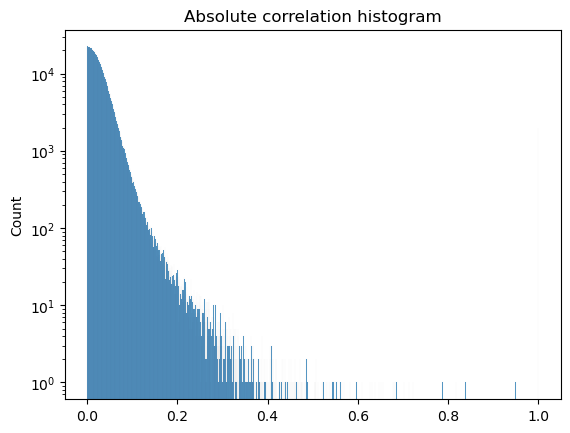

In [22]:
sns.histplot(np.abs(correlations)[np.triu_indices_from(correlations)], log_scale=(False, True))
plt.title('Absolute correlation histogram')


In [23]:
(corr_max_all[np.triu_indices_from(corr_max_all, 1)] > 0.3).sum()


997

In [24]:
(np.abs(correlations)[np.triu_indices_from(correlations, 1)] > 0.3).sum()


537

Text(0.5, 1.0, 'Absolute maximum correlations')

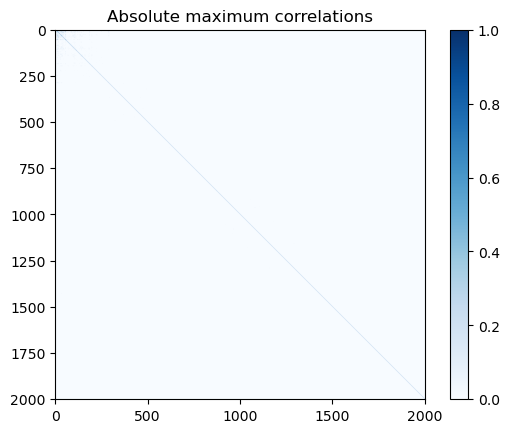

In [26]:
shw = plt.imshow(
    np.multiply(corr_max_all, corr_max_all>0.3),
    cmap=plt.cm.Blues, vmin=0, vmax=1)
bar = plt.colorbar(shw)
plt.title('Absolute maximum correlations')


Text(0.5, 1.0, 'Absolute maximum correlations')

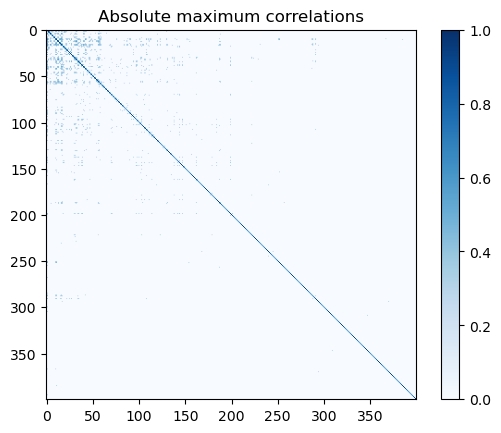

In [27]:
shw = plt.imshow(
    np.multiply(corr_max_all, corr_max_all>0.3)[:400,:400],
    cmap=plt.cm.Blues, vmin=0, vmax=1)
bar = plt.colorbar(shw)
plt.title('Absolute maximum correlations')


In [28]:
rows, cols = np.where(corr_max_all>0.3)
rows_lim = rows[rows < cols]
cols_lim = cols[rows < cols]


Text(0.5, 1.0, 'Absolute maximum correlations')

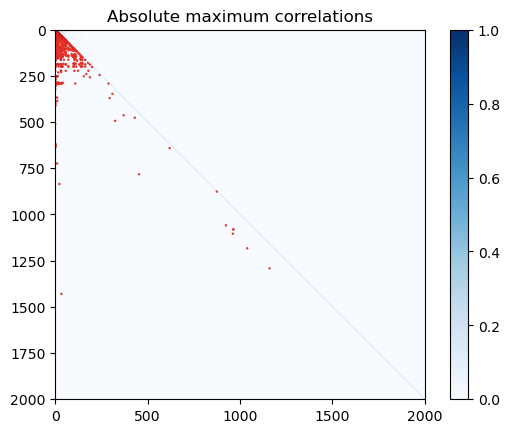

In [30]:
shw = plt.imshow(
    np.multiply(corr_max_all, corr_max_all>0.3),
    cmap=plt.cm.Blues, vmin=0, vmax=1)
bar = plt.colorbar(shw)
sct = plt.scatter(
    rows_lim, cols_lim, s=0.5,
    c=corr_max_all[rows_lim, cols_lim],
    cmap=plt.cm.Reds, vmin=-1, vmax=1,
)
plt.title('Absolute maximum correlations')


In [78]:
selected_pairs = np.array([rows_lim, cols_lim]).T

write_np(selected_pairs, f'{main_dir}/data/models/pymc/css_kernel_rho/selected_pairs_rho.npy')


In [13]:
selected_pairs = load_np(f'{main_dir}/data/models/pymc/css_kernel_rho/selected_pairs_rho.npy')


## Fit normative model for covariance pairs

---

For every selected pair, covariance will be fitted as implemented in 3.2.3.

In [15]:
import aesara.tensor as at

def run_pymc_advi_covariance_on_kernel_pairs(kernel_name1, kernel_name2, multiplicity=1000):
    stored_model_file = f'{main_dir}/data/models/pymc/css_kernel_rho/{kernel_name1},{kernel_name2}_pymc_advi_rho.nc'
    if file_exists(stored_model_file, path_name=''):
        try:
            advi_model_idata_cov = az.from_netcdf(stored_model_file)
            if type(advi_model_idata_cov) == az.data.inference_data.InferenceData:
                return ((kernel_name1, kernel_name2), stored_model_file)
            else:
                os.remove(stored_model_file)
        except:
            os.remove(stored_model_file)
            
    
    # sample from required columns
    sample_df = demography_extended_df[['age', 'site', 'sex', kernel_name1, kernel_name2]].copy()

    # Data preperation
    age = sample_df['age'].values
    age_standardized = (age - age.mean()) / age.std()
    thickness_v1 = sample_df[kernel_name1].values
    thickness_v1_standardized = (thickness_v1 - thickness_v1.mean()) / thickness_v1.std()
    thickness_v2 = sample_df[kernel_name2].values
    thickness_v2_standardized = (thickness_v2 - thickness_v2.mean()) / thickness_v2.std()
    thicknesses_standardized = np.concatenate([thickness_v1_standardized[:, np.newaxis], thickness_v2_standardized[:, np.newaxis]], axis=1)
    site_idxs, sites = pd.factorize(sample_df['site'])
    sex_idxs, sexes = pd.factorize(sample_df['sex'])

    # multiple weights from the same pair
    age_standardized_mult = np.repeat(age_standardized[np.newaxis,:], multiplicity, axis=0).reshape(-1)
    sex_idxs_mult = np.repeat(sex_idxs[np.newaxis,:], multiplicity, axis=0).reshape(-1)
    site_idxs_mult = np.repeat(site_idxs[np.newaxis,:], multiplicity, axis=0).reshape(-1)

    combination_weights_mult = []
    combined_thicknesses_mult = []
    for i in range(multiplicity):
        # a weight to combine two variables with
        combination_weights = (4*(np.random.uniform(size=thicknesses_standardized.shape) - 0.5))
        combination_weights_mult.append(combination_weights)

        # combine values
        combined_thicknesses = np.multiply(thicknesses_standardized, combination_weights).sum(1)
        combined_thicknesses_mult.append(combined_thicknesses)

    combination_weights_mult = np.concatenate(combination_weights_mult)
    combined_thicknesses_mult = np.concatenate(combined_thicknesses_mult)

    # Splines to model nonlinear age effects on thickness
    # number of spline nuts (could be tuned)
    num_knots = 3
    knot_list = np.quantile(age_standardized, np.linspace(0, 1, num_knots))
    # create b spline basis for regression using patsy
    B_spline_age = patsy.dmatrix(
        "bs(age_standardized, knots=knots, degree=3, include_intercept=True) - 1",
        {"age_standardized": age_standardized_mult, "knots": knot_list[1:-1]},
    )

    coords = {
        "site": sites,
        "sex": sexes,
        "splines": np.arange(B_spline_age.shape[1]),
        "obs_id": np.arange(len(site_idxs_mult)),
    }

    # loading previously fitted priors to use as constants
    advi_model_idata_v1 = az.from_netcdf(f'{main_dir}/data/models/pymc/css_kernel/{kernel_name1}_pymc_advi.nc')
    advi_model_idata_v2 = az.from_netcdf(f'{main_dir}/data/models/pymc/css_kernel/{kernel_name2}_pymc_advi.nc')

    kernel_advi_model_cov = pm.Model(coords=coords)

    # a nonlinear spline model (see https://www.pymc.io/projects/examples/en/latest/case_studies/spline.html)
    with kernel_advi_model_cov:
        # minibatch variables
        age_standardized_t = pm.Minibatch(age_standardized_mult, 512,)
        sex_idx_t = pm.Minibatch(sex_idxs_mult, 512)
        site_idx_t = pm.Minibatch(site_idxs_mult, 512)
        B_spline_age_t = pm.Minibatch(B_spline_age, 512)
        combined_thicknesses_t = pm.Minibatch(combined_thicknesses_mult, 512)
        combination_weights_t = pm.Minibatch(combination_weights_mult, 512)

        # Hyperpriors for site groups (as if we have random group effects)
        mu_intercept_site_rho = pm.Normal('mu_intercept_site_rho', mu=0, sigma=10)
        sigma_intercept_site_rho = pm.HalfNormal("sigma_intercept_site_rho", sigma=10)
        # sigma_error_site_cov = pm.HalfNormal("sigma_error_site_cov", sigma=10)


        # Priors (for covariance/correlation)
        # sex effects (similar to fixed sex effects (intercept only))
        intercept_sex_rho = pm.Normal("intercept_sex_rho", mu=0, sigma=0.1, dims="sex")

        # site effects (similar to random site effects (intercept only))
        intercept_site_offset_rho = pm.Normal("intercept_site_offset_rho", mu=0, sigma=0.1, dims="site")
        intercept_site_rho = pm.Deterministic("intercept_site_rho", mu_intercept_site_rho + intercept_site_offset_rho * sigma_intercept_site_rho, dims="site")

        # age splines
        w_age_rho = pm.Normal("w_age_rho", mu=0, sigma=0.1, size=B_spline_age.shape[1], dims="splines")

        # Estimated covariance/correlation
        # z_est = pm.Deterministic("z_est", intercept_sex_rho[sex_idx_t] + intercept_site_rho[site_idx_t] + pm.math.dot(B_spline_age_t, w_age_rho.T), dims="obs_id")
        z_est = intercept_sex_rho[sex_idx_t] + intercept_site_rho[site_idx_t] + pm.math.dot(B_spline_age_t, w_age_rho.T)
        # rho_est = pm.Deterministic("rho_est", 2 * pm.math.sigmoid(intercept_sex_rho[sex_idx_t] + intercept_site_rho[site_idx_t] + pm.math.dot(B_spline_age_t, w_age_rho.T)) - 1)
        # rho_est = pm.Deterministic("rho_est", 2 * pm.math.sigmoid(z_est) - 1)
        rho_est = 2 * pm.math.sigmoid(z_est) - 1
    

        # Priors (constant priors, already fitted in previous models)
        # sex effects (similar to fixed sex effects (intercept only))
        # intercept_sex = pm.Normal("intercept_sex", mu=0, sigma=10, dims="sex")
        intercept_sex_v1 = pm.ConstantData("intercept_sex_v1", np.array(advi_model_idata_v1.posterior['intercept_sex'].stack(sample=("chain", "draw")).mean('sample')), dims="sex")
        intercept_sex_v2 = pm.ConstantData("intercept_sex_v2", np.array(advi_model_idata_v2.posterior['intercept_sex'].stack(sample=("chain", "draw")).mean('sample')), dims="sex")
    
        # site effects (similar to random site effects (intercept only))
        #a_site = pm.Normal("a_site", mu=mu_a_site, sigma=sigma_a_site, dims="site")
        # intercept_site_offset = pm.Normal("intercept_site_offset", mu=0, sigma=1, dims="site")
        # intercept_site = pm.Deterministic("intercept_site", mu_intercept_site + intercept_site_offset * sigma_intercept_site, dims="site")
        intercept_site_v1 = pm.ConstantData("intercept_site_v1", np.array(advi_model_idata_v1.posterior['intercept_site'].stack(sample=("chain", "draw")).mean('sample')), dims="site")
        intercept_site_v2 = pm.ConstantData("intercept_site_v2", np.array(advi_model_idata_v2.posterior['intercept_site'].stack(sample=("chain", "draw")).mean('sample')), dims="site")

        # age splines
        # w_age = pm.Normal("w_age", mu=0, sigma=10, size=B_spline_age.shape[1], dims="splines")
        w_age_v1 = pm.ConstantData("w_age_v1", np.array(advi_model_idata_v1.posterior['w_age'].stack(sample=("chain", "draw")).mean('sample')), dims="splines")
        w_age_v2 = pm.ConstantData("w_age_v2", np.array(advi_model_idata_v2.posterior['w_age'].stack(sample=("chain", "draw")).mean('sample')), dims="splines")

        # Estimated thickness
        # thickness_est = pm.Deterministic("thickness_est", intercept_sex[sex_idx_t] + intercept_site[site_idx_t] + pm.math.dot(B_spline_age_t, w_age.T))
        # thickness_est_v1 = pm.Deterministic("thickness_est_v1", intercept_sex_v1[sex_idx_t] + intercept_site_v1[site_idx_t] + pm.math.dot(B_spline_age_t, w_age_v1.T))
        thickness_est_v1 = intercept_sex_v1[sex_idx_t] + intercept_site_v1[site_idx_t] + pm.math.dot(B_spline_age_t, w_age_v1.T)
        # thickness_est_v2 = pm.Deterministic("thickness_est_v2", intercept_sex_v2[sex_idx_t] + intercept_site_v2[site_idx_t] + pm.math.dot(B_spline_age_t, w_age_v2.T))
        thickness_est_v2 = intercept_sex_v2[sex_idx_t] + intercept_site_v2[site_idx_t] + pm.math.dot(B_spline_age_t, w_age_v2.T)

        # Model error
        # nonlinear age error
        # w_error_age = pm.HalfCauchy("w_error_age", beta=5, size=B_spline_age.shape[1], dims="splines")
        w_error_age_v1 = pm.ConstantData("w_error_age_v1", np.array(advi_model_idata_v1.posterior['w_error_age'].stack(sample=("chain", "draw")).mean('sample')), dims="splines")
        w_error_age_v2 = pm.ConstantData("w_error_age_v2", np.array(advi_model_idata_v2.posterior['w_error_age'].stack(sample=("chain", "draw")).mean('sample')), dims="splines")

        # constant sex error
        # error_sex = pm.HalfCauchy("error_sex", beta=5, dims="sex")
        error_sex_v1 = pm.ConstantData("error_sex_v1", np.array(advi_model_idata_v1.posterior['error_sex'].stack(sample=("chain", "draw")).mean('sample')), dims="sex")
        error_sex_v2 = pm.ConstantData("error_sex_v2", np.array(advi_model_idata_v2.posterior['error_sex'].stack(sample=("chain", "draw")).mean('sample')), dims="sex")

        # random site error
        # error_site_offset = pm.HalfCauchy("error_site_offset", beta=5, dims="site")
        # error_site = pm.Deterministic("error_site", error_site_offset * sigma_error_site, dims="site")
        error_site_v1 = pm.ConstantData("error_site_v1", np.array(advi_model_idata_v1.posterior['error_site'].stack(sample=("chain", "draw")).mean('sample')), dims="site")
        error_site_v2 = pm.ConstantData("error_site_v2", np.array(advi_model_idata_v2.posterior['error_site'].stack(sample=("chain", "draw")).mean('sample')), dims="site")

        # Error estimate
        # thickness_error = pm.Deterministic("thickness_error", error_sex[sex_idx_t] + error_site[site_idx_t] + pm.math.dot(B_spline_age_t, w_error_age.T))
        # thickness_error_v1 = pm.Deterministic("thickness_error_v1", error_sex_v1[sex_idx_t] + error_site_v1[site_idx_t] + pm.math.dot(B_spline_age_t, w_error_age_v1.T))
        thickness_error_v1 = error_sex_v1[sex_idx_t] + error_site_v1[site_idx_t] + pm.math.dot(B_spline_age_t, w_error_age_v1.T)
        # thickness_error_v2 = pm.Deterministic("thickness_error_v2", error_sex_v2[sex_idx_t] + error_site_v2[site_idx_t] + pm.math.dot(B_spline_age_t, w_error_age_v2.T))
        thickness_error_v2 = error_sex_v2[sex_idx_t] + error_site_v2[site_idx_t] + pm.math.dot(B_spline_age_t, w_error_age_v2.T)

        # Likelihood (sampling distribution) of observations
        # Likelihood estimation from a bivariate normal with known mean and variance, but unknown covariance
        # combined_mu = pm.Deterministic("combined_mu", pm.math.sum(at.math.mul(combination_weights_t, at.stacklists([thickness_est_v1, thickness_est_v2]).T), axis=1))
        combined_mu = pm.math.sum(at.math.mul(combination_weights_t, at.stacklists([thickness_est_v1, thickness_est_v2]).T), axis=1)
        # combined_sigma = pm.Deterministic("combined_sigma", at.math.mul(combination_weights_t, at.stacklists([thickness_error_v1, thickness_error_v2]).T))
        combined_sigma = at.math.mul(combination_weights_t, at.stacklists([thickness_error_v1, thickness_error_v2]).T)
        # combined_var = pm.Deterministic("combined_var", pm.math.sqrt(combined_sigma[:, 0]**2 + combined_sigma[:, 1]**2 + 2 * combined_sigma[:, 0] * combined_sigma[:, 1] * rho_est))
        combined_var = pm.math.sqrt(combined_sigma[:, 0]**2 + combined_sigma[:, 1]**2 + 2 * combined_sigma[:, 0] * combined_sigma[:, 1] * rho_est)
    
        # Likelihood estimation for covariance
        likelihood = pm.Normal(
            "likelihood",
            mu=combined_mu,
            sigma=combined_var,
            observed=combined_thicknesses_t,
            total_size=len(sample_df) * multiplicity,
        )

        # run ADVI with minibatch
        error_approx_cov = pm.fit(100000, callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])
    
        # sample from trace
        advi_model_idata_cov = pm.sample_prior_predictive()
        advi_model_idata_cov.extend(error_approx_cov.sample(2000))
        pm.sample_posterior_predictive(advi_model_idata_cov, extend_inferencedata=True)
    
    advi_model_idata_cov.to_netcdf(ensure_dir(stored_model_file))
    return ((kernel_name1, kernel_name2), stored_model_file)

        

In [21]:
advi_model_idata_v1 = az.from_netcdf(f'{main_dir}/data/models/pymc/css_kernel/{kernel_name1}_pymc_advi.nc')

advi_model_idata_v1.posterior

<xarray.Dataset>
Dimensions:                (chain: 1, draw: 2000, sex: 2, site: 3, splines: 5,
                            thickness_est_dim_0: 512, thickness_error_dim_0: 512)
Coordinates:
  * chain                  (chain) int64 0
  * draw                   (draw) int64 0 1 2 3 4 5 ... 1995 1996 1997 1998 1999
  * sex                    (sex) float64 1.0 0.0
  * site                   (site) object 'HCP-YA-site_0' ... 'HCP-A-site_0'
  * splines                (splines) int64 0 1 2 3 4
  * thickness_est_dim_0    (thickness_est_dim_0) int64 0 1 2 3 ... 509 510 511
  * thickness_error_dim_0  (thickness_error_dim_0) int64 0 1 2 3 ... 509 510 511
Data variables: (12/13)
    mu_intercept_site      (chain, draw) float64 ...
    intercept_sex          (chain, draw, sex) float64 ...
    intercept_site_offset  (chain, draw, site) float64 ...
    w_age                  (chain, draw, splines) float64 ...
    sigma_intercept_site   (chain, draw) float64 ...
    sigma_error_site       (chain, draw) float64 ...
    ...                     ...
    error_sex              (chain, draw, sex) float64 ...
    error_site_offset      (chain, draw, site) float64 ...
    intercept_site         (chain, draw, site) float64 ...
    thickness_est          (chain, draw, thickness_est_dim_0) float64 ...
    error_site             (chain, draw, site) float64 ...
    thickness_error        (chain, draw, thickness_error_dim_0) float64 ...
Attributes:
    created_at:                 2022-10-26T00:57:06.930264
    arviz_version:              0.12.1
    inference_library:          pymc
    inference_library_version:  4.2.2

In [16]:
((kernel_name1, kernel_name2), stored_model_file) = run_pymc_advi_covariance_on_kernel_pairs("thickness_css_0", "thickness_css_1")

saved_model = az.from_netcdf(f'{main_dir}/data/models/pymc/css_kernel_rho/{kernel_name1},{kernel_name2}_pymc_advi_rho.nc')


In [ ]:
1

In [20]:
os.remove(stored_model_file)

In [17]:
saved_model.posterior

<xarray.Dataset>
Dimensions:                    (chain: 1, draw: 2000, sex: 2, site: 3,
                                splines: 5)
Coordinates:
  * chain                      (chain) int64 0
  * draw                       (draw) int64 0 1 2 3 4 ... 1996 1997 1998 1999
  * sex                        (sex) float64 1.0 0.0
  * site                       (site) object 'HCP-YA-site_0' ... 'HCP-A-site_0'
  * splines                    (splines) int64 0 1 2 3 4
Data variables:
    mu_intercept_site_rho      (chain, draw) float64 ...
    intercept_sex_rho          (chain, draw, sex) float64 ...
    intercept_site_offset_rho  (chain, draw, site) float64 ...
    w_age_rho                  (chain, draw, splines) float64 ...
    sigma_intercept_site_rho   (chain, draw) float64 ...
    intercept_site_rho         (chain, draw, site) float64 ...
Attributes:
    created_at:                 2023-05-23T09:13:36.821349
    arviz_version:              0.12.1
    inference_library:          pymc
    inference_library_version:  4.2.2

In [19]:
%%time
%%capture multiprocessing_log

import multiprocessing
import time

def mute():
    sys.stdout = open(os.devnull, 'w')

PROCESSES = 16
with multiprocessing.Pool(PROCESSES, initializer=mute) as pool:
    collected_results = pool.starmap(
        run_pymc_advi_covariance_on_kernel_pairs,
        zip(
            [f'thickness_css_{selected_pairs[i][0]}' for i in range(selected_pairs.shape[0])],
            [f'thickness_css_{selected_pairs[i][1]}' for i in range(selected_pairs.shape[0])]
        )
    )


WARNING (aesara.link.c.cmodule): `ModuleCache.refresh` Found a key without a cached shared library (/home/ubuntu/.aesara/compiledir_Linux-5.4--generic-x86_64-with-glibc2.31-x86_64-3.10.6-64/tmprm0miqf8/key.pkl); deleting it.
Finished [100%]: Average Loss = 643.05
Sampling: [intercept_sex_rho, intercept_site_offset_rho, likelihood, mu_intercept_site_rho, sigma_intercept_site_rho, w_age_rho]
Finished [100%]: Average Loss = 397.32
Sampling: [intercept_sex_rho, intercept_site_offset_rho, likelihood, mu_intercept_site_rho, sigma_intercept_site_rho, w_age_rho]
Finished [100%]: Average Loss = 666.39
Finished [100%]: Average Loss = 670.75
Finished [100%]: Average Loss = 801.75
Sampling: [intercept_sex_rho, intercept_site_offset_rho, likelihood, mu_intercept_site_rho, sigma_intercept_site_rho, w_age_rho]
Sampling: [intercept_sex_rho, intercept_site_offset_rho, likelihood, mu_intercept_site_rho, sigma_intercept_site_rho, w_age_rho]
Finished [100%]: Average Loss = 665.93
Sampling: [intercept_sex_

CPU times: user 2.94 s, sys: 1.54 s, total: 4.48 s
Wall time: 2h 26min 19s


In [ ]:
collected_results

---

Example visualization of correlation between first two kernels:

In [1]:
%%time

kernel_name1, kernel_name2 = 'thickness_css_0', 'thickness_css_1'
multiplicity = 1000

# loading fitted models
advi_model_idata_v1 = az.from_netcdf(f'{main_dir}/data/models/pymc/css_kernel/{kernel_name1}_pymc_advi.nc')
advi_model_idata_v2 = az.from_netcdf(f'{main_dir}/data/models/pymc/css_kernel/{kernel_name2}_pymc_advi.nc')
advi_model_idata_cov = az.from_netcdf(f'{main_dir}/data/models/pymc/css_kernel_rho/{kernel_name1},{kernel_name2}_pymc_advi_rho.nc')

# sample from required columns
sample_df = demography_extended_df[['age', 'site', 'sex', kernel_name1, kernel_name2]].copy()

# Data preperation
age = sample_df['age'].values
age_standardized = (age - age.mean()) / age.std()
thickness_v1 = sample_df[kernel_name1].values
thickness_v1_standardized = (thickness_v1 - thickness_v1.mean()) / thickness_v1.std()
thickness_v2 = sample_df[kernel_name2].values
thickness_v2_standardized = (thickness_v2 - thickness_v2.mean()) / thickness_v2.std()
thicknesses_standardized = np.concatenate([thickness_v1_standardized[:, np.newaxis], thickness_v2_standardized[:, np.newaxis]], axis=1)
site_idxs, sites = pd.factorize(sample_df['site'])
sex_idxs, sexes = pd.factorize(sample_df['sex'])

# multiple weights from the same pair
age_standardized_mult = np.repeat(age_standardized[np.newaxis,:], multiplicity, axis=0).reshape(-1)
sex_idxs_mult = np.repeat(sex_idxs[np.newaxis,:], multiplicity, axis=0).reshape(-1)
site_idxs_mult = np.repeat(site_idxs[np.newaxis,:], multiplicity, axis=0).reshape(-1)

combination_weights_mult = []
combined_thicknesses_mult = []
for i in range(multiplicity):
    # a weight to combine two variables with
    combination_weights = (4*(np.random.uniform(size=thicknesses_standardized.shape) - 0.5))
    combination_weights_mult.append(combination_weights)

    # combine values
    combined_thicknesses = np.multiply(thicknesses_standardized, combination_weights).sum(1)
    combined_thicknesses_mult.append(combined_thicknesses)

combination_weights_mult = np.concatenate(combination_weights_mult)
combined_thicknesses_mult = np.concatenate(combined_thicknesses_mult)

# Splines to model nonlinear age effects on thickness
# number of spline nuts (could be tuned)
num_knots = 3
knot_list = np.quantile(age_standardized, np.linspace(0, 1, num_knots))
# create b spline basis for regression using patsy
B_spline_age = patsy.dmatrix(
    "bs(age_standardized, knots=knots, degree=3, include_intercept=True) - 1",
    {"age_standardized": age_standardized_mult, "knots": knot_list[1:-1]},
)

coords = {
    "site": sites,
    "sex": sexes,
    "splines": np.arange(B_spline_age.shape[1]),
    "obs_id": np.arange(len(site_idxs_mult)),
}

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

sigmoid = lambda x: 1/(1 + np.exp(-x))

sample_df['compcorr'] = np.prod(thicknesses_standardized, 1)

# sns.scatterplot(
#     data=sample_df,
#     x='age',
#     y='compcorr',
#     ax=ax,
#     linewidth=0,
#     hue='site',
#     palette="Set1",
# #     palette=mpl.cm.Set1,
#     alpha = 0.3,
# #     color=[0.3,0.6,0.9,0.5],
# )

# ax.set_xlim(20,40)
# ax.set_ylim(2.2,3)

ax.set_xlabel('Age', fontsize=28)
ax.set_ylabel('Correlation', fontsize=28)

# thickness = sample_df['thickness_v2'].values

for idx in np.unique(site_idxs):
    xi = xr.DataArray(np.linspace(np.min(age), np.max(age), 200), dims=["obs_id"])
    selection = (xi > np.min(age[site_idxs == idx])) & (xi < np.max(age[site_idxs == idx]))
    post = advi_model_idata_cov.posterior
    
    prediction_B_spline_age = patsy.dmatrix(
        "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
        {"xi": ((xi - age.mean()) / age.std()), "knots": knot_list[1:-1]},
    )

    y_ppc_mu = (
        post['intercept_sex_rho'].stack(sample=("chain", "draw"))[0].data +
        post['intercept_site_rho'].stack(sample=("chain", "draw"))[idx].data +
        np.dot(
            prediction_B_spline_age,
            post['w_age_rho'].stack(sample=("chain", "draw"))
        )
    )

#     y_ppc_sigma = (
#         post['error_sex'].stack(sample=("chain", "draw"))[0].data +
#         post['error_site'].stack(sample=("chain", "draw"))[idx].data +
#         np.dot(
#             prediction_B_spline_age,
#             post['w_error_age'].stack(sample=("chain", "draw"))
#         )
#     )

    # y_ppc_alpha = post['thickness_skewness'].stack(sample=("chain", "draw")).data
    
    # need to ensure the correctness
    quantiles = [0.50,]
    # quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]
    
    # thickness_quantiles = {
    #     q: (
    #         (
    #             y_ppc_mu.mean(1) + stats.norm.ppf(q=q) * y_ppc_sigma.mean(1)
    #         )  * thickness.std() +
    #         thickness.mean()
    #     ) for q in quantiles
    # }

#     # centile plot
#     for q1, q2, alpha in [(0.01, 0.99, 0.1), (0.05, 0.95, 0.3), (0.25, 0.75, 0.5)]:
#         ax.fill_between(
#             xi[selection],
#             thickness_quantiles[q1][selection],
#             thickness_quantiles[q2][selection],
#             alpha=alpha,
#             color=np.array(mpl.cm.Set1(idx)[:3])*0.8,
#         )

    ax.plot(
        xi[selection],
        (2 * sigmoid(y_ppc_mu) - 1)[selection, :],
        c=np.array(mpl.cm.Set1(idx)[:3]),
        lw=0.5,
        alpha=0.1
    )
    
    ax.plot(
        xi[selection],
        (2 * sigmoid(y_ppc_mu.mean(1)) - 1)[selection],
        c=np.array(mpl.cm.Set1(idx)[:3])*0.6,
        lw=4,
    )

ax.set_ylim([-1,1])

NameError: name 'az' is not defined

In [ ]:
y_ppc_mu.shape

(200, 2000)

In [59]:
np.prod(thicknesses_standardized, 1).mean()

-0.3947750333309404

In [57]:
correlations[0,1]


-0.3947750333309403

CPU times: user 7.17 s, sys: 7.05 s, total: 14.2 s
Wall time: 1.06 s


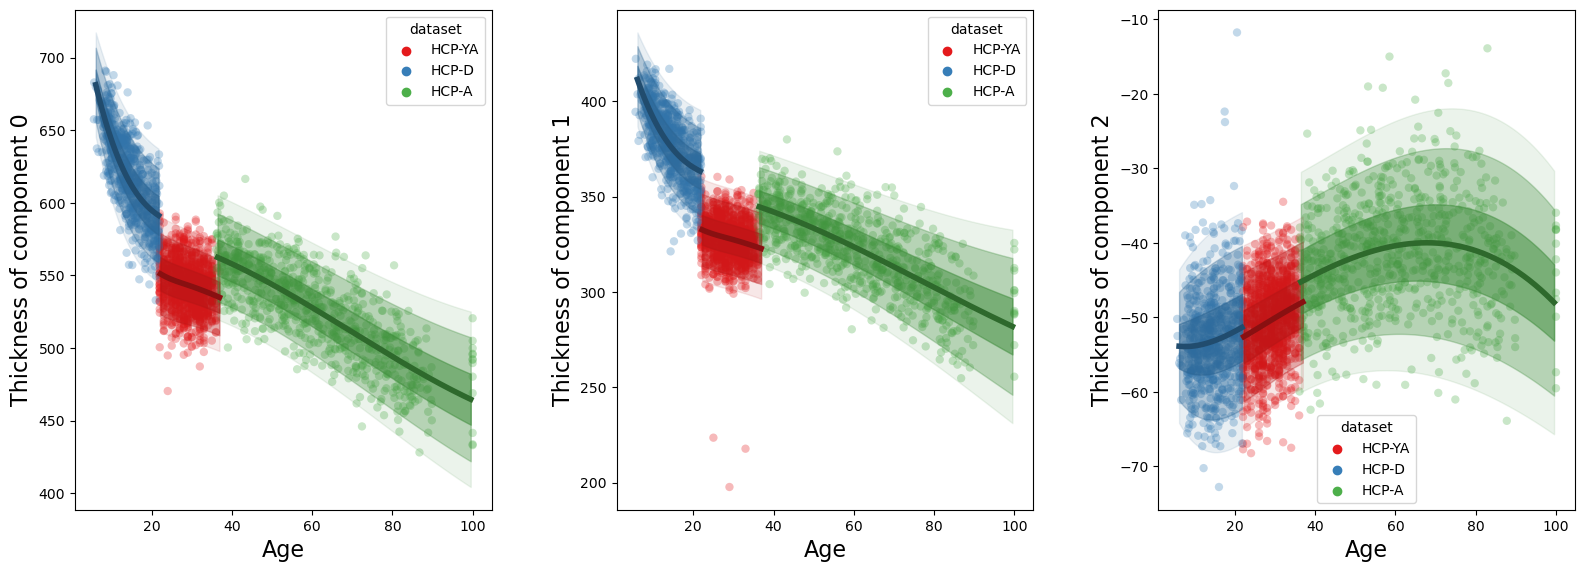

In [106]:
%%time

# sample from required columns
sample_df = demography_extended_df

# Data preperation
age = sample_df['age'].values
age_standardized = (age - age.mean()) / age.std()
site_idxs, sites = pd.factorize(sample_df['site'])
sex_idxs, sexes = pd.factorize(sample_df['sex'])


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for c in range(3):
    ax = axes[c]
    kernel_name = f'thickness_css_{c}'
    thickness = sample_df[kernel_name].values
    thickness_mean = thickness.mean()
    thickness_std = thickness.std()
    thickness_standardized = (thickness - thickness_mean) / thickness_std
    
    sns.scatterplot(
        data=demography_extended_df,
        x='age',
        y=kernel_name,
        ax=ax,
        linewidth=0,
        hue='dataset',
        palette="Set1",
        alpha = 0.3,
    )

    ax.set_xlabel('Age', fontsize=16)
    ax.set_ylabel(f'Thickness of component {c}', fontsize=16)

    for idx in np.unique(site_idxs):
        xi = xr.DataArray(np.linspace(np.min(age), np.max(age), 200), dims=["obs_id"])
        selection = (xi > np.min(age[site_idxs == idx])) & (xi < np.max(age[site_idxs == idx]))
        # post = advi_model_idata.posterior
        advi_model_idata = az.from_netcdf(f'{main_dir}/data/models/pymc/css_kernel/{kernel_name}_pymc_advi.nc')
        post = advi_model_idata.posterior

        prediction_B_spline_age = patsy.dmatrix(
            "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
            {"xi": ((xi - age.mean()) / age.std()), "knots": knot_list[1:-1]},
        )

        y_ppc_mu = (
            post['intercept_sex'].stack(sample=("chain", "draw"))[0].data +
            post['intercept_site'].stack(sample=("chain", "draw"))[idx].data +
            np.dot(
                prediction_B_spline_age,
                post['w_age'].stack(sample=("chain", "draw"))
            )
        )
        y_ppc_mu_mean = y_ppc_mu.mean(1)

        y_ppc_sigma = (
            post['error_sex'].stack(sample=("chain", "draw"))[0].data +
            post['error_site'].stack(sample=("chain", "draw"))[idx].data +
            np.dot(
                prediction_B_spline_age,
                post['w_error_age'].stack(sample=("chain", "draw"))
            )
        )
        y_ppc_sigma_mean = y_ppc_sigma.mean(1)

        # y_ppc_alpha = post['thickness_skewness'].stack(sample=("chain", "draw")).data

        # need to ensure the correctness
        quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]

        thickness_quantiles = {
            q: (
                (
                    y_ppc_mu_mean + stats.norm.ppf(q=q) * y_ppc_sigma_mean
                )  * thickness_std +
                thickness_mean
            ) for q in quantiles
        }

        # centile plot
        for q1, q2, alpha in [(0.01, 0.99, 0.1), (0.05, 0.95, 0.3), (0.25, 0.75, 0.5)]:
            ax.fill_between(
                xi[selection],
                thickness_quantiles[q1][selection],
                thickness_quantiles[q2][selection],
                alpha=alpha,
                color=np.array(mpl.cm.Set1(idx)[:3])*0.8,
            )

        ax.plot(
            xi[selection],
            thickness_quantiles[0.5][selection],
            c=np.array(mpl.cm.Set1(idx)[:3])*0.6,
            lw=4,
        )

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.)


CPU times: user 10.4 s, sys: 9.96 s, total: 20.3 s
Wall time: 1.61 s


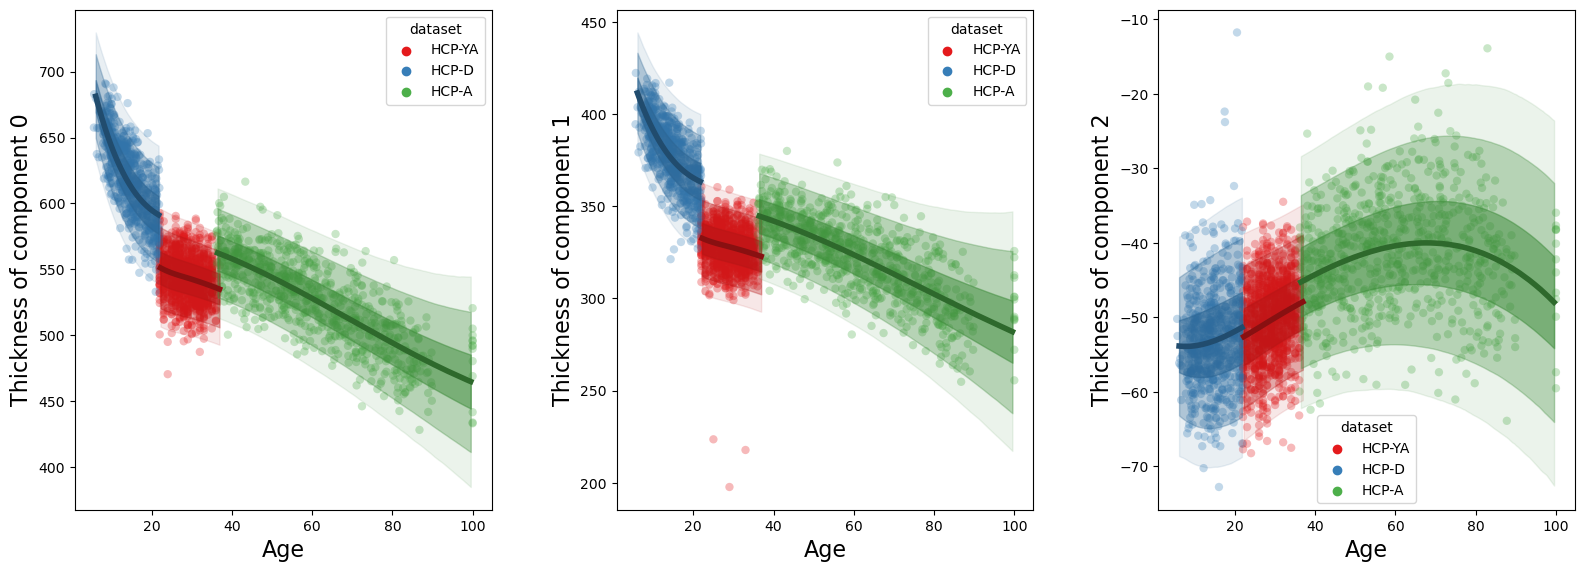

In [134]:
%%time

# sample from required columns
sample_df = demography_extended_df

# Data preperation
age = sample_df['age'].values
age_standardized = (age - age.mean()) / age.std()
site_idxs, sites = pd.factorize(sample_df['site'])
sex_idxs, sexes = pd.factorize(sample_df['sex'])


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for c in range(3):
    ax = axes[c]
    kernel_name = f'thickness_css_{c}'
    thickness = sample_df[kernel_name].values
    thickness_mean = thickness.mean()
    thickness_std = thickness.std()
    thickness_standardized = (thickness - thickness_mean) / thickness_std
    
    sns.scatterplot(
        data=demography_extended_df,
        x='age',
        y=kernel_name,
        ax=ax,
        linewidth=0,
        hue='dataset',
        palette="Set1",
        alpha = 0.3,
    )

    ax.set_xlabel('Age', fontsize=16)
    ax.set_ylabel(f'Thickness of component {c}', fontsize=16)

    for idx in np.unique(site_idxs):
        xi = xr.DataArray(np.linspace(np.min(age), np.max(age), 200), dims=["obs_id"])
        selection = (xi > np.min(age[site_idxs == idx])) & (xi < np.max(age[site_idxs == idx]))
        # post = advi_model_idata.posterior
        advi_model_idata = az.from_netcdf(f'{main_dir}/data/models/pymc/css_kernel/{kernel_name}_pymc_advi.nc')
        post = advi_model_idata.posterior

        prediction_B_spline_age = patsy.dmatrix(
            "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
            {"xi": ((xi - age.mean()) / age.std()), "knots": knot_list[1:-1]},
        )

        y_ppc_mu = (
            post['intercept_sex'].stack(sample=("chain", "draw"))[0].data +
            post['intercept_site'].stack(sample=("chain", "draw"))[idx].data +
            np.dot(
                prediction_B_spline_age,
                post['w_age'].stack(sample=("chain", "draw"))
            )
        )
        y_ppc_mu_mean = y_ppc_mu.mean(1)

        y_ppc_sigma = (
            post['error_sex'].stack(sample=("chain", "draw"))[0].data +
            post['error_site'].stack(sample=("chain", "draw"))[idx].data +
            np.dot(
                prediction_B_spline_age,
                post['w_error_age'].stack(sample=("chain", "draw"))
            )
        )
        y_ppc_sigma_mean = y_ppc_sigma.mean(1)

        # y_ppc_alpha = post['thickness_skewness'].stack(sample=("chain", "draw")).data

        # need to ensure the correctness
        quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]

        thickness_quantiles = {
            q: (
                (
                    np.quantile(((y_ppc_mu + stats.norm.ppf(q=q) * y_ppc_sigma)), q, 1)
                )  * thickness_std +
                thickness_mean
            ) for q in quantiles
        }

        # centile plot
        for q1, q2, alpha in [(0.01, 0.99, 0.1), (0.05, 0.95, 0.3), (0.25, 0.75, 0.5)]:
            ax.fill_between(
                xi[selection],
                thickness_quantiles[q1][selection],
                thickness_quantiles[q2][selection],
                alpha=alpha,
                color=np.array(mpl.cm.Set1(idx)[:3])*0.8,
            )

        ax.plot(
            xi[selection],
            thickness_quantiles[0.5][selection],
            c=np.array(mpl.cm.Set1(idx)[:3])*0.6,
            lw=4,
        )

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.)


CPU times: user 7.64 s, sys: 7.67 s, total: 15.3 s
Wall time: 1.11 s


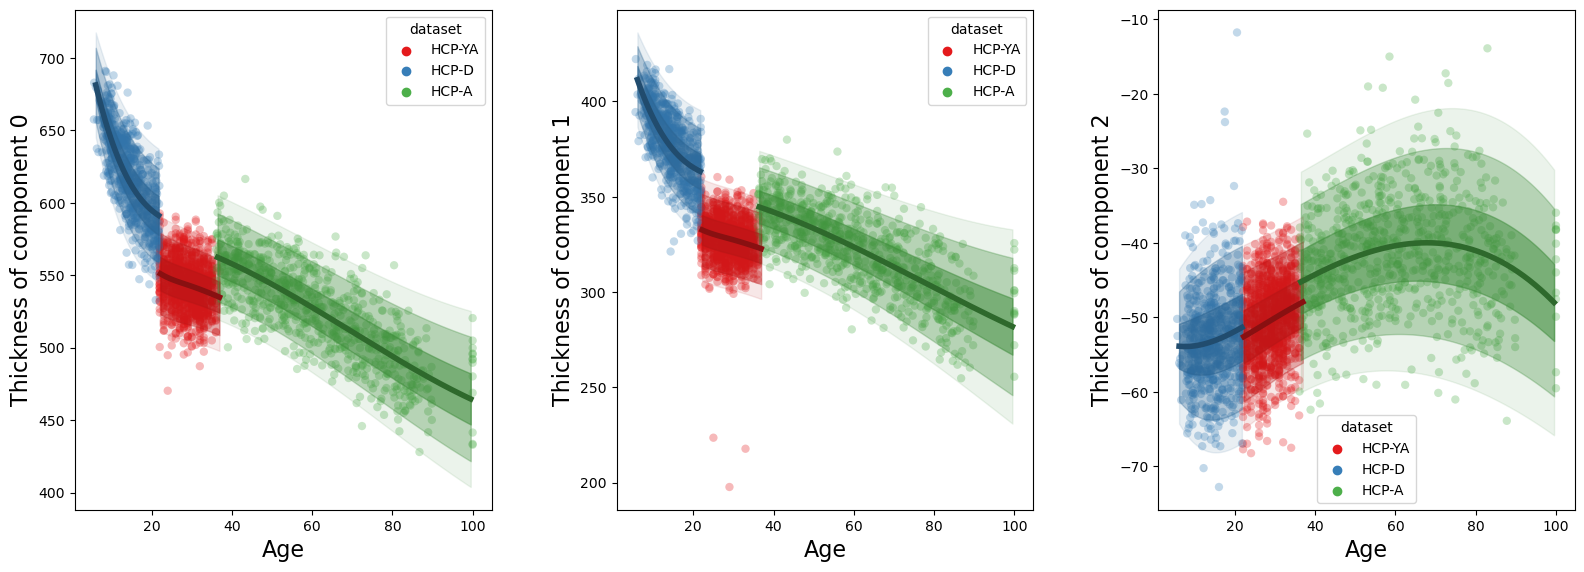

In [137]:
%%time

# sample from required columns
sample_df = demography_extended_df

# Data preperation
age = sample_df['age'].values
age_standardized = (age - age.mean()) / age.std()
site_idxs, sites = pd.factorize(sample_df['site'])
sex_idxs, sexes = pd.factorize(sample_df['sex'])


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for c in range(3):
    ax = axes[c]
    kernel_name = f'thickness_css_{c}'
    thickness = sample_df[kernel_name].values
    thickness_mean = thickness.mean()
    thickness_std = thickness.std()
    thickness_standardized = (thickness - thickness_mean) / thickness_std
    
    sns.scatterplot(
        data=demography_extended_df,
        x='age',
        y=kernel_name,
        ax=ax,
        linewidth=0,
        hue='dataset',
        palette="Set1",
        alpha = 0.3,
    )

    ax.set_xlabel('Age', fontsize=16)
    ax.set_ylabel(f'Thickness of component {c}', fontsize=16)

    for idx in np.unique(site_idxs):
        xi = xr.DataArray(np.linspace(np.min(age), np.max(age), 200), dims=["obs_id"])
        selection = (xi > np.min(age[site_idxs == idx])) & (xi < np.max(age[site_idxs == idx]))
        # post = advi_model_idata.posterior
        advi_model_idata = az.from_netcdf(f'{main_dir}/data/models/pymc/css_kernel/{kernel_name}_pymc_advi.nc')
        post = advi_model_idata.posterior

        prediction_B_spline_age = patsy.dmatrix(
            "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
            {"xi": ((xi - age.mean()) / age.std()), "knots": knot_list[1:-1]},
        )

        y_ppc_mu = (
            post['intercept_sex'].stack(sample=("chain", "draw"))[0].data +
            post['intercept_site'].stack(sample=("chain", "draw"))[idx].data +
            np.dot(
                prediction_B_spline_age,
                post['w_age'].stack(sample=("chain", "draw"))
            )
        )
        y_ppc_mu_mean = y_ppc_mu.mean(1)

        y_ppc_sigma = (
            post['error_sex'].stack(sample=("chain", "draw"))[0].data +
            post['error_site'].stack(sample=("chain", "draw"))[idx].data +
            np.dot(
                prediction_B_spline_age,
                post['w_error_age'].stack(sample=("chain", "draw"))
            )
        )
        y_ppc_sigma_mean = y_ppc_sigma.mean(1)

        # y_ppc_alpha = post['thickness_skewness'].stack(sample=("chain", "draw")).data

        # need to ensure the correctness
        quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]

        thickness_quantiles = {
            q: (
                (
                    y_ppc_mu_mean + stats.norm.ppf(q=q) * np.quantile(y_ppc_sigma, q)
                    # np.quantile(((y_ppc_mu + stats.norm.ppf(q=q) * y_ppc_sigma)), q, 1)
                )  * thickness_std +
                thickness_mean
            ) for q in quantiles
        }

        # centile plot
        for q1, q2, alpha in [(0.01, 0.99, 0.1), (0.05, 0.95, 0.3), (0.25, 0.75, 0.5)]:
            ax.fill_between(
                xi[selection],
                thickness_quantiles[q1][selection],
                thickness_quantiles[q2][selection],
                alpha=alpha,
                color=np.array(mpl.cm.Set1(idx)[:3])*0.8,
            )

        ax.plot(
            xi[selection],
            thickness_quantiles[0.5][selection],
            c=np.array(mpl.cm.Set1(idx)[:3])*0.6,
            lw=4,
        )

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.)


In [152]:
# y_ppc_mu_mean.shape
# post['intercept_sex'].stack(sample=("chain", "draw"))[0].data
# y_ppc_mu
# y_ppc_mu_mean + stats.norm.ppf(q=0.5) * y_ppc_sigma_mean

# np.quantile(((y_ppc_mu + stats.norm.ppf(q=0.75) * y_ppc_sigma)), 0.75, 1)

# y_ppc_mu_mean + stats.norm.ppf(q=0.75) * np.sqrt(y_ppc_sigma_mean**2 + y_ppc_sigma.var(1))

# post['intercept_sex'].stack(sample=("chain", "draw"))[0].data.mean()

# advi_model_idata.prior['intercept_sex'].stack(sample=("chain", "draw"))[0].data.mean()

# with az.from_netcdf(f'{main_dir}/data/models/pymc/css_kernel/{kernel_name}_pymc_advi.nc') as advi_model_idata:


coords = {
    "site": sites,
    "sex": sexes,
    "splines": np.arange(B_spline_age.shape[1]),
    "obs_id": np.arange(len(site_idxs_mult)),
}

with pm.Model(coords=coords) as model:
    x = pm.sample_posterior_predictive(advi_model_idata, sample_dims)


## Store fitted covariance models

---

Combine and store the fitted covariance models


In [20]:
%%time

# import tqdm.notebook as tqdm
# Load all posterior distributions of kernels
# rho_kernel_posteriors = xr.concat([
#     az.from_netcdf(f'{main_dir}/data/models/pymc/css_kernel_rho/thickness_css_{selected_pairs[i][0]},thickness_css_{selected_pairs[i][1]}_pymc_advi_rho.nc').posterior
#     for i in (range(selected_pairs.shape[0]))
# ], "kernel_pair")

rho_kernel_idata = {}

for i in (range(selected_pairs.shape[0])):
    kernel_name1, kernel_name2 = f'thickness_css_{selected_pairs[i][0]}', f'thickness_css_{selected_pairs[i][1]}'
    rho_kernel_idata[(kernel_name1, kernel_name2)] = az.from_netcdf(f'{main_dir}/data/models/pymc/css_kernel_rho/{kernel_name1},{kernel_name2}_pymc_advi_rho.nc')


CPU times: user 1min 7s, sys: 1.98 s, total: 1min 9s
Wall time: 1min 9s


In [21]:
%%time
# concatenate posteriors along a new dimension
rho_kernel_posteriors = xr.concat([rho_kernel_idata[(f'thickness_css_{selected_pairs[i][0]}', f'thickness_css_{selected_pairs[i][1]}')].posterior for i in range(selected_pairs.shape[0])], "kernel_pair")
rho_kernel_posteriors


CPU times: user 1min 9s, sys: 3.12 s, total: 1min 12s
Wall time: 1min 12s


<xarray.Dataset>
Dimensions:                    (chain: 1, draw: 2000, kernel_pair: 997, sex: 2,
                                site: 3, splines: 5)
Coordinates:
  * chain                      (chain) int64 0
  * draw                       (draw) int64 0 1 2 3 4 ... 1996 1997 1998 1999
  * sex                        (sex) float64 1.0 0.0
  * site                       (site) object 'HCP-YA-site_0' ... 'HCP-A-site_0'
  * splines                    (splines) int64 0 1 2 3 4
Dimensions without coordinates: kernel_pair
Data variables:
    mu_intercept_site_rho      (kernel_pair, chain, draw) float64 -0.545 ... ...
    intercept_sex_rho          (kernel_pair, chain, draw, sex) float64 2.724 ...
    intercept_site_offset_rho  (kernel_pair, chain, draw, site) float64 0.660...
    w_age_rho                  (kernel_pair, chain, draw, splines) float64 -0...
    sigma_intercept_site_rho   (kernel_pair, chain, draw) float64 1.395 ... 0...
    intercept_site_rho         (kernel_pair, chain, draw, site) float64 0.375...
Attributes:
    created_at:                 2023-05-23T09:13:36.821349
    arviz_version:              0.12.1
    inference_library:          pymc
    inference_library_version:  4.2.2

In [ ]:
%%time
rho_kernel_posteriors.to_netcdf(f'{main_dir}/data/models/pymc/combined_css_rho_kernel_posteriors_pymc_advi.nc')


In [22]:
%%time
rho_kernel_posterior_means = rho_kernel_posteriors.mean(dim=["chain", "draw"])
rho_kernel_posterior_means


CPU times: user 475 ms, sys: 141 ms, total: 616 ms
Wall time: 614 ms


<xarray.Dataset>
Dimensions:                    (kernel_pair: 997, sex: 2, site: 3, splines: 5)
Coordinates:
  * sex                        (sex) float64 1.0 0.0
  * site                       (site) object 'HCP-YA-site_0' ... 'HCP-A-site_0'
  * splines                    (splines) int64 0 1 2 3 4
Dimensions without coordinates: kernel_pair
Data variables:
    mu_intercept_site_rho      (kernel_pair) float64 -0.5655 ... 0.09197
    intercept_sex_rho          (kernel_pair, sex) float64 2.725 2.474 ... 0.2716
    intercept_site_offset_rho  (kernel_pair, site) float64 0.6598 ... -0.2159
    w_age_rho                  (kernel_pair, splines) float64 -0.2683 ... 0.4539
    sigma_intercept_site_rho   (kernel_pair) float64 1.332 0.5182 ... 0.2577
    intercept_site_rho         (kernel_pair, site) float64 0.3132 ... 0.03634

In [23]:
%%time
rho_kernel_posterior_means.to_netcdf(f'{main_dir}/data/models/pymc/combined_css_rho_kernel_posterior_means_pymc_advi.nc')


CPU times: user 31.5 ms, sys: 0 ns, total: 31.5 ms
Wall time: 29.9 ms


In [24]:
%%time
rho_kernel_posteriors.to_netcdf(f'{main_dir}/data/models/pymc/combined_css_rho_kernel_posteriors_pymc_advi.nc')


CPU times: user 7.77 s, sys: 502 ms, total: 8.27 s
Wall time: 8.27 s


In [25]:
%%time
# load the stored posterior means
rho_kernel_posterior_means = xr.open_dataset(f'{main_dir}/data/models/pymc/combined_css_rho_kernel_posterior_means_pymc_advi.nc')
rho_kernel_posterior_means


CPU times: user 88.4 ms, sys: 479 µs, total: 88.9 ms
Wall time: 85.3 ms


<xarray.Dataset>
Dimensions:                    (kernel_pair: 997, sex: 2, site: 3, splines: 5)
Coordinates:
  * sex                        (sex) float64 1.0 0.0
  * site                       (site) object 'HCP-YA-site_0' ... 'HCP-A-site_0'
  * splines                    (splines) int64 0 1 2 3 4
Dimensions without coordinates: kernel_pair
Data variables:
    mu_intercept_site_rho      (kernel_pair) float64 ...
    intercept_sex_rho          (kernel_pair, sex) float64 ...
    intercept_site_offset_rho  (kernel_pair, site) float64 ...
    w_age_rho                  (kernel_pair, splines) float64 ...
    sigma_intercept_site_rho   (kernel_pair) float64 ...
    intercept_site_rho         (kernel_pair, site) float64 ...

In [26]:
%%time
# load the stored posterior means
rho_kernel_posteriors = xr.open_dataset(f'{main_dir}/data/models/pymc/combined_css_rho_kernel_posteriors_pymc_advi.nc')
rho_kernel_posteriors


CPU times: user 74.5 ms, sys: 11.8 ms, total: 86.3 ms
Wall time: 84.2 ms


<xarray.Dataset>
Dimensions:                    (chain: 1, draw: 2000, kernel_pair: 997, sex: 2,
                                site: 3, splines: 5)
Coordinates:
  * chain                      (chain) int64 0
  * draw                       (draw) int64 0 1 2 3 4 ... 1996 1997 1998 1999
  * sex                        (sex) float64 1.0 0.0
  * site                       (site) object 'HCP-YA-site_0' ... 'HCP-A-site_0'
  * splines                    (splines) int64 0 1 2 3 4
Dimensions without coordinates: kernel_pair
Data variables:
    mu_intercept_site_rho      (kernel_pair, chain, draw) float64 ...
    intercept_sex_rho          (kernel_pair, chain, draw, sex) float64 ...
    intercept_site_offset_rho  (kernel_pair, chain, draw, site) float64 ...
    w_age_rho                  (kernel_pair, chain, draw, splines) float64 ...
    sigma_intercept_site_rho   (kernel_pair, chain, draw) float64 ...
    intercept_site_rho         (kernel_pair, chain, draw, site) float64 ...
Attributes:
    created_at:                 2023-05-23T09:13:36.821349
    arviz_version:              0.12.1
    inference_library:          pymc
    inference_library_version:  4.2.2

## Load stored kernel models

---


In [27]:
%%time
# load the stored posterior means
kernel_posterior_means = xr.open_dataset(f'{main_dir}/data/models/pymc/combined_css_kernel_posterior_means_pymc_advi.nc')
kernel_posterior_means


CPU times: user 69.5 ms, sys: 6.37 ms, total: 75.9 ms
Wall time: 283 ms


<xarray.Dataset>
Dimensions:                (kernel: 2001, sex: 2, site: 3, splines: 5,
                            thickness_est_dim_0: 512, thickness_error_dim_0: 512)
Coordinates:
  * sex                    (sex) float64 1.0 0.0
  * site                   (site) object 'HCP-YA-site_0' ... 'HCP-A-site_0'
  * splines                (splines) int64 0 1 2 3 4
  * thickness_est_dim_0    (thickness_est_dim_0) int64 0 1 2 3 ... 509 510 511
  * thickness_error_dim_0  (thickness_error_dim_0) int64 0 1 2 3 ... 509 510 511
Dimensions without coordinates: kernel
Data variables: (12/13)
    mu_intercept_site      (kernel) float64 ...
    intercept_sex          (kernel, sex) float64 ...
    intercept_site_offset  (kernel, site) float64 ...
    w_age                  (kernel, splines) float64 ...
    sigma_intercept_site   (kernel) float64 ...
    sigma_error_site       (kernel) float64 ...
    ...                     ...
    error_sex              (kernel, sex) float64 ...
    error_site_offset      (kernel, site) float64 ...
    intercept_site         (kernel, site) float64 ...
    thickness_est          (kernel, thickness_est_dim_0) float64 ...
    error_site             (kernel, site) float64 ...
    thickness_error        (kernel, thickness_error_dim_0) float64 ...

In [28]:
%%time
# load the stored posterior means
kernel_posteriors = xr.open_dataset(f'{main_dir}/data/models/pymc/combined_css_kernel_posteriors_pymc_advi.nc')
kernel_posteriors


CPU times: user 54.5 ms, sys: 739 µs, total: 55.2 ms
Wall time: 508 ms


<xarray.Dataset>
Dimensions:                (chain: 1, draw: 2000, kernel: 2001, sex: 2,
                            site: 3, splines: 5, thickness_est_dim_0: 512,
                            thickness_error_dim_0: 512)
Coordinates:
  * chain                  (chain) int64 0
  * draw                   (draw) int64 0 1 2 3 4 5 ... 1995 1996 1997 1998 1999
  * sex                    (sex) float64 1.0 0.0
  * site                   (site) object 'HCP-YA-site_0' ... 'HCP-A-site_0'
  * splines                (splines) int64 0 1 2 3 4
  * thickness_est_dim_0    (thickness_est_dim_0) int64 0 1 2 3 ... 509 510 511
  * thickness_error_dim_0  (thickness_error_dim_0) int64 0 1 2 3 ... 509 510 511
Dimensions without coordinates: kernel
Data variables: (12/13)
    mu_intercept_site      (kernel, chain, draw) float64 ...
    intercept_sex          (kernel, chain, draw, sex) float64 ...
    intercept_site_offset  (kernel, chain, draw, site) float64 ...
    w_age                  (kernel, chain, draw, splines) float64 ...
    sigma_intercept_site   (kernel, chain, draw) float64 ...
    sigma_error_site       (kernel, chain, draw) float64 ...
    ...                     ...
    error_sex              (kernel, chain, draw, sex) float64 ...
    error_site_offset      (kernel, chain, draw, site) float64 ...
    intercept_site         (kernel, chain, draw, site) float64 ...
    thickness_est          (kernel, chain, draw, thickness_est_dim_0) float64 ...
    error_site             (kernel, chain, draw, site) float64 ...
    thickness_error        (kernel, chain, draw, thickness_error_dim_0) float64 ...
Attributes:
    created_at:                 2022-10-26T00:57:06.930264
    arviz_version:              0.12.1
    inference_library:          pymc
    inference_library_version:  4.2.2

#### Modelling mean thickness 🧠

---


In [29]:
# mean thickness vector representation
mean_thickness_vector = np.ones(css_kernel_eigenvectors.shape[0]) / css_kernel_eigenvectors.shape[0]
mean_thickness_vector_encoded = np.dot(mean_thickness_vector.reshape(1,-1), css_kernel_eigenvectors)


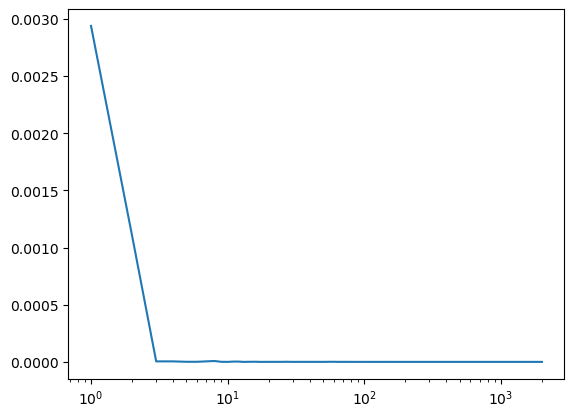

In [31]:
ax = sns.lineplot(y=(mean_thickness_vector_encoded.ravel()**2)/(np.linalg.norm(mean_thickness_vector_encoded)), x=1+np.arange(mean_thickness_vector_encoded.shape[1]))
ax.set_xscale('log')
# ax.set_yscale('log')


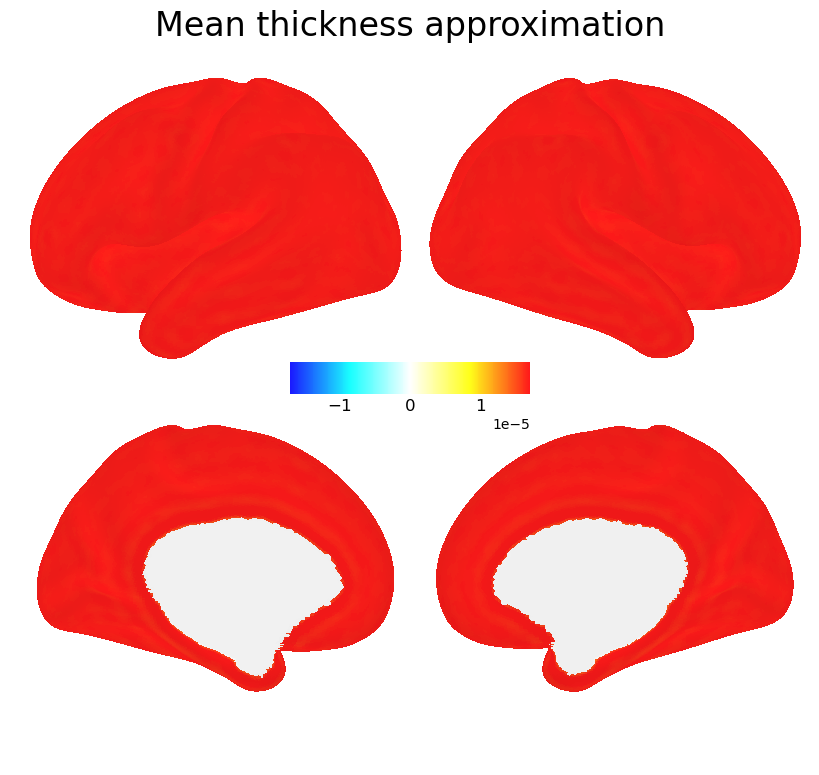

In [32]:
plot_data_on_brain_surface(
    np.dot(mean_thickness_vector_encoded, css_kernel_eigenvectors.T)[0],
    title=f"Mean thickness approximation",
    symmetric_cbar=True,
)


/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


CPU times: user 18.2 s, sys: 123 ms, total: 18.3 s
Wall time: 18 s


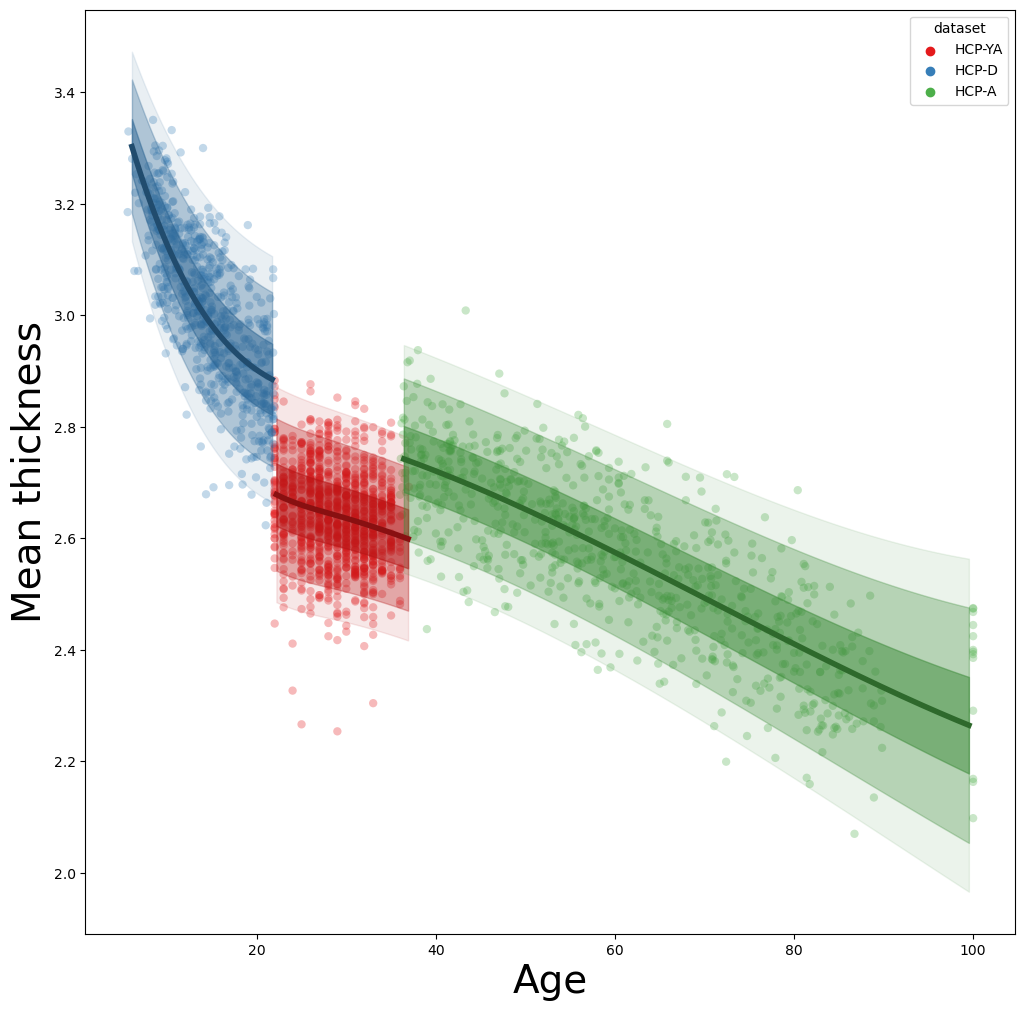

In [105]:
%%time

sigmoid = lambda x: 1/(1 + np.exp(-x))

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# thickness_mean = mean_thickness_vector_encoded.dot(all_thickness_data_encoded.mean(0))
# thickness_std = np.power(
#     np.multiply(
#         mean_thickness_vector_encoded.reshape(-1,),
#         all_thickness_data_encoded.std(0)
#     ).dot(
#         correlations
#     ).dot(
#         np.multiply(
#             mean_thickness_vector_encoded.reshape(-1,),
#             all_thickness_data_encoded.std(0)
#         ),
#     ),
#     0.5
# )

sns.scatterplot(
    data=demography_df,
    x='age',
    y='thickness',
    ax=ax,
    linewidth=0,
    hue='dataset',
    palette="Set1",
#     palette=mpl.cm.Set1,
    alpha = 0.3,
#     color=[0.3,0.6,0.9,0.5],
)

# ax.set_xlim(20,40)
# ax.set_ylim(2.2,3)

ax.set_xlabel('Age', fontsize=28)
ax.set_ylabel('Mean thickness', fontsize=28)

xi = xr.DataArray(np.linspace(np.min(age), np.max(age), 200), dims=["obs_id"])
    
prediction_B_spline_age = patsy.dmatrix(
    "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
    {"xi": ((xi - age.mean()) / age.std()), "knots": knot_list[1:-1]},
)

sparse_filler = sparse.coo_matrix(
    (np.ones(selected_pairs.shape[0]), (selected_pairs[:, 0], selected_pairs[:, 1])),
    shape=(kernel_posterior_means.dims['kernel'], kernel_posterior_means.dims['kernel'])
)

for idx in np.unique(site_idxs):
    selection = (xi > np.min(age[site_idxs == idx])) & (xi < np.max(age[site_idxs == idx]))
    # post = advi_model_idata.posterior
    
    kernels_y_ppc_mu_mean = (
        kernel_posterior_means['intercept_sex'].isel(sex=0) +
        kernel_posterior_means['intercept_site'].isel(site=idx) +
        xr.dot(
            xr.DataArray(np.asarray(prediction_B_spline_age), dims=["obs_id", "splines"]),
            kernel_posterior_means['w_age']
        )
    ) * xr.DataArray(all_thickness_data_encoded.std(0), dims=["kernel"]) + xr.DataArray(all_thickness_data_encoded.mean(0), dims=["kernel"])
    y_ppc_mu_mean = np.array(xr.dot(
        xr.DataArray(mean_thickness_vector_encoded.reshape(-1), dims=["kernel"]),
        kernels_y_ppc_mu_mean
    ))
    
    rho_ppc_mean = 2 * sigmoid(
        rho_kernel_posterior_means['intercept_sex_rho'].isel(sex=0).data +
        rho_kernel_posterior_means['intercept_site_rho'].isel(site=idx).data +
        xr.DataArray(prediction_B_spline_age, dims=["obs_id", "splines"]).dot(
            rho_kernel_posterior_means['w_age_rho']
        )
    ) - 1

    kernels_y_ppc_sigma_mean = (
        kernel_posterior_means['error_sex'].isel(sex=0) +
        kernel_posterior_means['error_site'].isel(site=idx) +
        xr.dot(
            xr.DataArray(np.asarray(prediction_B_spline_age), dims=["obs_id", "splines"]),
            kernel_posterior_means['w_error_age']
        )
    ) * xr.DataArray(all_thickness_data_encoded.std(0), dims=["kernel"])
    y_ppc_sigma_mean = np.zeros(200)
    for i in range(200):
        sparse_correlations = sparse_filler.copy()
        sparse_correlations.data = rho_ppc_mean[i]
        sparse_correlations = (sparse_correlations + sparse_correlations.T)
        sparse_correlations.setdiag(1)
        sparse_correlations = sparse_correlations.tocsr()
        y_ppc_sigma_mean[i] = np.power(
            sparse_correlations.dot(
                np.multiply(
                    mean_thickness_vector_encoded.reshape(-1,),
                    np.array(kernels_y_ppc_sigma_mean).T[i]
                )
            ).dot(
                np.multiply(
                    mean_thickness_vector_encoded.reshape(-1,),
                    np.array(kernels_y_ppc_sigma_mean).T[i]
                ),
            ),
            0.5
        )

    # y_ppc_alpha = post['thickness_skewness'].stack(sample=("chain", "draw")).data
    
    # need to ensure the correctness
    quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]
    
    thickness_quantiles = {
        q: (
            (
                y_ppc_mu_mean + stats.norm.ppf(q=q) * y_ppc_sigma_mean
            )
            # * thickness_std +
            # thickness_mean
        ) for q in quantiles
    }

    # centile plot
    for q1, q2, alpha in [(0.01, 0.99, 0.1), (0.05, 0.95, 0.3), (0.25, 0.75, 0.5)]:
        ax.fill_between(
            xi[selection],
            thickness_quantiles[q1][selection],
            thickness_quantiles[q2][selection],
            alpha=alpha,
            color=np.array(mpl.cm.Set1(idx)[:3])*0.8,
        )
    
    ax.plot(
        xi[selection],
        thickness_quantiles[0.5][selection],
        c=np.array(mpl.cm.Set1(idx)[:3])*0.6,
        lw=4,
    )


/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


CPU times: user 2min 14s, sys: 1min 31s, total: 3min 46s
Wall time: 3min 45s


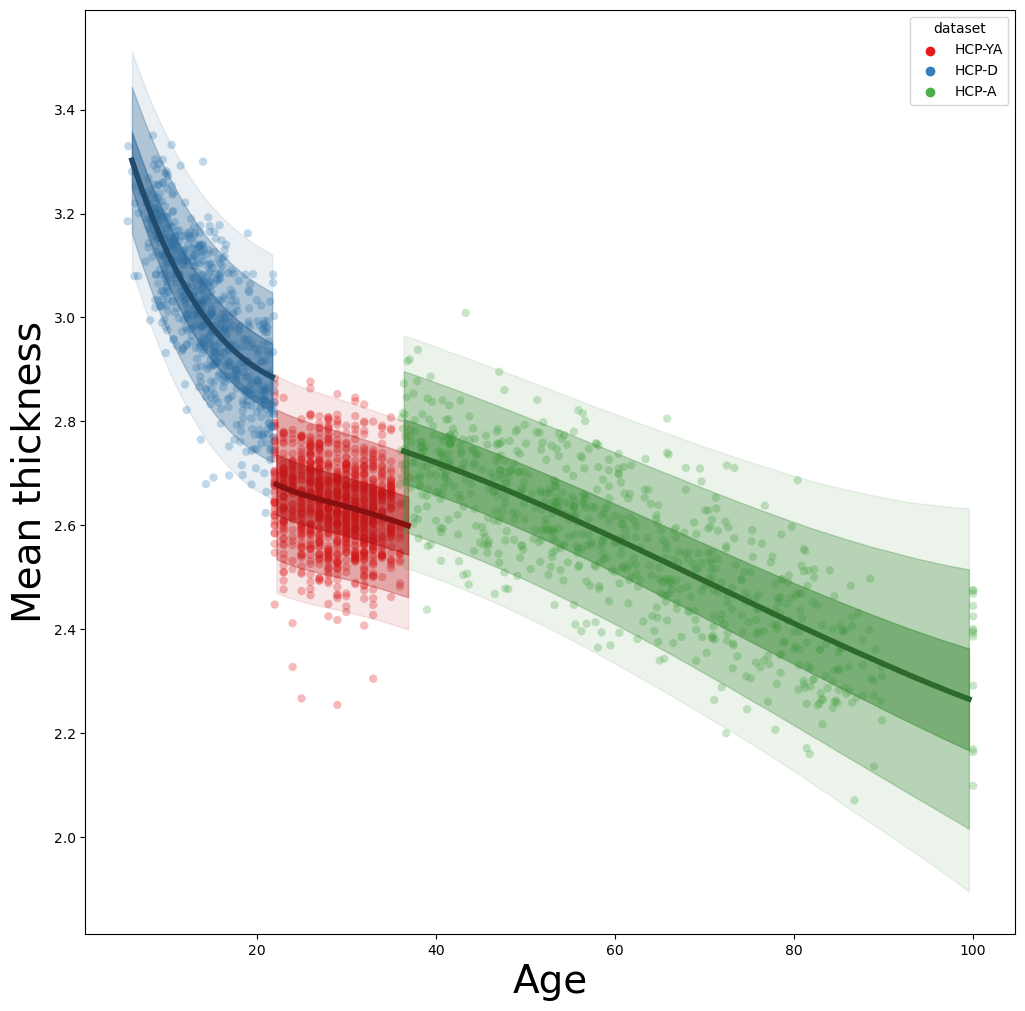

In [106]:
%%time

sigmoid = lambda x: 1/(1 + np.exp(-x))

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# thickness_mean = mean_thickness_vector_encoded.dot(all_thickness_data_encoded.mean(0))
# thickness_std = np.power(
#     np.multiply(
#         mean_thickness_vector_encoded.reshape(-1,),
#         all_thickness_data_encoded.std(0)
#     ).dot(
#         correlations
#     ).dot(
#         np.multiply(
#             mean_thickness_vector_encoded.reshape(-1,),
#             all_thickness_data_encoded.std(0)
#         ),
#     ),
#     0.5
# )

sns.scatterplot(
    data=demography_df,
    x='age',
    y='thickness',
    ax=ax,
    linewidth=0,
    hue='dataset',
    palette="Set1",
#     palette=mpl.cm.Set1,
    alpha = 0.3,
#     color=[0.3,0.6,0.9,0.5],
)

# ax.set_xlim(20,40)
# ax.set_ylim(2.2,3)

ax.set_xlabel('Age', fontsize=28)
ax.set_ylabel('Mean thickness', fontsize=28)

for idx in np.unique(site_idxs):
    xi = xr.DataArray(np.linspace(np.min(age), np.max(age), 200), dims=["obs_id"])
    selection = (xi > np.min(age[site_idxs == idx])) & (xi < np.max(age[site_idxs == idx]))
    # post = advi_model_idata.posterior
    
    prediction_B_spline_age = patsy.dmatrix(
        "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
        {"xi": ((xi - age.mean()) / age.std()), "knots": knot_list[1:-1]},
    )
    
    kernels_y_ppc_mu = (
        kernel_posteriors['intercept_sex'].isel(sex=0) +
        kernel_posteriors['intercept_site'].isel(site=idx) +
        xr.dot(
            xr.DataArray(np.asarray(prediction_B_spline_age), dims=["obs_id", "splines"]),
            kernel_posteriors['w_age']
        )
    ) * xr.DataArray(all_thickness_data_encoded.std(0), dims=["kernel"]) + xr.DataArray(all_thickness_data_encoded.mean(0), dims=["kernel"])
    y_ppc_mu = xr.DataArray(np.array(xr.dot(
        xr.DataArray(mean_thickness_vector_encoded.reshape(-1), dims=["kernel"]),
        kernels_y_ppc_mu
    )), dims=['chain', 'draw', 'obs_id']).stack(sample=("chain", "draw"))
    
    rho_ppc_mean = 2 * sigmoid(
        rho_kernel_posterior_means['intercept_sex_rho'].isel(sex=0).data +
        rho_kernel_posterior_means['intercept_site_rho'].isel(site=idx).data +
        xr.DataArray(prediction_B_spline_age, dims=["obs_id", "splines"]).dot(
            rho_kernel_posterior_means['w_age_rho']
        )
    ) - 1

    kernels_y_ppc_sigma = (
        kernel_posteriors['error_sex'].isel(sex=0) +
        kernel_posteriors['error_site'].isel(site=idx) +
        xr.dot(
            xr.DataArray(np.asarray(prediction_B_spline_age), dims=["obs_id", "splines"]),
            kernel_posteriors['w_error_age']
        )
    ) * xr.DataArray(all_thickness_data_encoded.std(0), dims=["kernel"])
    y_ppc_sigma = np.zeros((200, 2000))
    encoded_sigma = np.multiply(mean_thickness_vector_encoded.reshape(-1, 1, 1), np.array(kernels_y_ppc_sigma.stack(sample=("chain", "draw"))))
    for obs in range(200):
        sparse_correlations = sparse_filler.copy()
        sparse_correlations.data = rho_ppc_mean[i]
        sparse_correlations = (sparse_correlations + sparse_correlations.T)
        sparse_correlations.setdiag(1)
        sparse_correlations = sparse_correlations.tocsr()
        # dimensions: ('kernel', 'chain', 'draw', 'obs_id')
        encoded_sigma_sample = encoded_sigma[:, obs, :]
        y_ppc_sigma[obs] = np.power(np.multiply(sparse_correlations.dot(encoded_sigma_sample), encoded_sigma_sample).sum(0), 0.5)
        # y_ppc_sigma[obs] = np.multiply(correlations.dot(encoded_sigma_sample), encoded_sigma_sample).sum(0)
    y_ppc_sigma = xr.DataArray(y_ppc_sigma, dims=["obs_id", "sample"])
    

    # y_ppc_alpha = post['thickness_skewness'].stack(sample=("chain", "draw")).data
    
    # need to ensure the correctness
    quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]
    
    thickness_quantiles = {
        q: (
            (
                # y_ppc_mu_mean + stats.norm.ppf(q=q) * y_ppc_sigma_mean
                # y_ppc_mu.mean('sample') + stats.norm.ppf(q=q) * y_ppc_sigma.mean("sample")
                np.quantile(((y_ppc_mu + stats.norm.ppf(q=q) * y_ppc_sigma)), q, 1)
            )
            # * thickness_std +
            # thickness_mean
        ) for q in quantiles
    }

    # centile plot
    for q1, q2, alpha in [(0.01, 0.99, 0.1), (0.05, 0.95, 0.3), (0.25, 0.75, 0.5)]:
        ax.fill_between(
            xi[selection],
            thickness_quantiles[q1][selection],
            thickness_quantiles[q2][selection],
            alpha=alpha,
            color=np.array(mpl.cm.Set1(idx)[:3])*0.8,
        )
    
    ax.plot(
        xi[selection],
        thickness_quantiles[0.5][selection],
        c=np.array(mpl.cm.Set1(idx)[:3])*0.6,
        lw=4,
    )


#### Modelling arbitrary queries: thickness of an atlas region 🎯

---


In [87]:
from sklearn.preprocessing import normalize

In [88]:
# load the glasser atlas
atlas_file = f'{main_dir}/data/templates/hcp_parcel/Q1-Q6_RelatedValidation210.CorticalAreas_dil_Final_Final_Areas_Group_Colors.32k_fs_LR.dlabel.nii'
atlas = nib.load(atlas_file)


In [89]:
# mean thickness vector representation
region_idx = 8
query_thickness_vector = normalize((atlas.get_fdata()==region_idx).astype(float).reshape(1,-1), norm='l1')[0]
query_thickness_vector_encoded = np.dot(query_thickness_vector.reshape(1,-1), css_kernel_eigenvectors)


In [90]:
ax = sns.lineplot(y=(query_thickness_vector_encoded.ravel()**2)/(np.linalg.norm(query_thickness_vector_encoded)), x=1+np.arange(query_thickness_vector_encoded.shape[1]))
ax.set_xscale('log')
# ax.set_yscale('log')


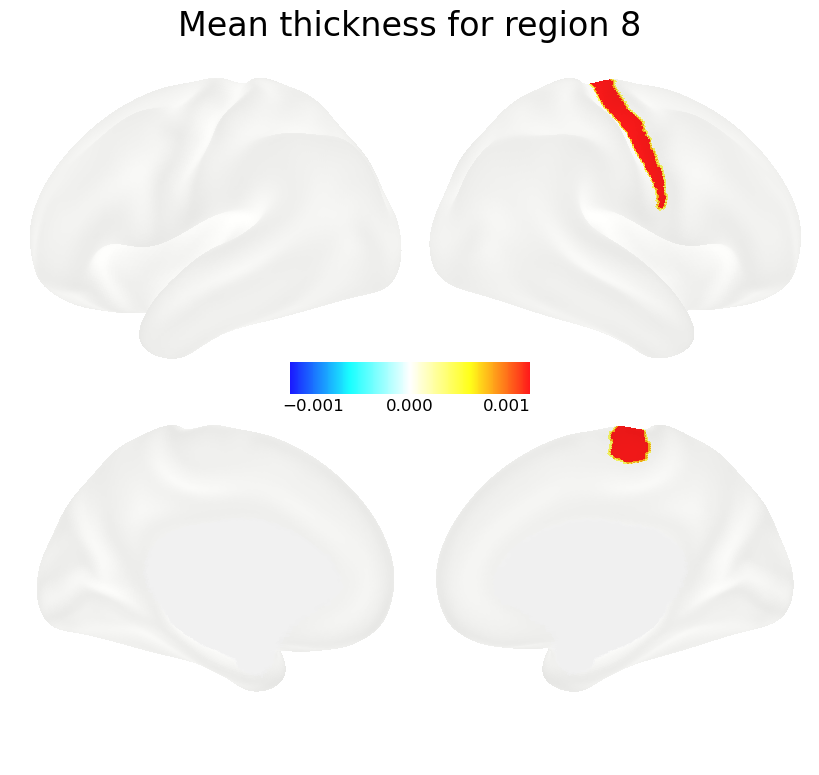

In [141]:
plot_data_on_brain_surface(
    query_thickness_vector,
    # np.dot(query_thickness_vector_encoded, css_kernel_eigenvectors.T)[0],
    title=f"Mean thickness for region {region_idx}",
    symmetric_cbar=True, vmin=0, vmax=query_thickness_vector.max()
)


In [142]:
plot_data_on_brain_surface(
    # query_thickness_vector,
    np.dot(query_thickness_vector_encoded, css_kernel_eigenvectors.T)[0],
    title=f"Mean thickness approximation for region {region_idx}",
    symmetric_cbar=True, vmin=0, vmax=query_thickness_vector.max()
)


In [93]:
np.power(
    sparse_correlations.dot(
        np.multiply(
            query_thickness_vector_encoded.reshape(-1,),
            np.array(kernels_y_ppc_sigma_mean).T[i]
        )
    ).dot(
        np.multiply(
            query_thickness_vector_encoded.reshape(-1,),
            np.array(kernels_y_ppc_sigma_mean).T[i]
        ),
    ),
    0.5
)

0.03196752559708816

In [107]:
%%time

sigmoid = lambda x: 1/(1 + np.exp(-x))

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

demography_df['query_thickness'] = query_thickness_vector.dot(all_thickness_data.T)

sns.scatterplot(
    data=demography_df,
    x='age',
    y='query_thickness',
    ax=ax,
    linewidth=0,
    hue='dataset',
    palette="Set1",
#     palette=mpl.cm.Set1,
    alpha = 0.3,
#     color=[0.3,0.6,0.9,0.5],
)

# ax.set_xlim(20,40)
# ax.set_ylim(2.2,3)

ax.set_xlabel('Age', fontsize=28)
ax.set_ylabel('Mean thickness of the exact query', fontsize=28)

sparse_filler = sparse.coo_matrix(
    (np.ones(selected_pairs.shape[0]), (selected_pairs[:, 0], selected_pairs[:, 1])),
    shape=(kernel_posterior_means.dims['kernel'], kernel_posterior_means.dims['kernel'])
)

for idx in np.unique(site_idxs):
    xi = xr.DataArray(np.linspace(np.min(age), np.max(age), 200), dims=["obs_id"])
    selection = (xi > np.min(age[site_idxs == idx])) & (xi < np.max(age[site_idxs == idx]))
    # post = advi_model_idata.posterior
    
    prediction_B_spline_age = patsy.dmatrix(
        "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
        {"xi": ((xi - age.mean()) / age.std()), "knots": knot_list[1:-1]},
    )
    
    kernels_y_ppc_mu_mean = (
        kernel_posterior_means['intercept_sex'].isel(sex=0) +
        kernel_posterior_means['intercept_site'].isel(site=idx) +
        xr.dot(
            xr.DataArray(np.asarray(prediction_B_spline_age), dims=["obs_id", "splines"]),
            kernel_posterior_means['w_age']
        )
    ) * xr.DataArray(all_thickness_data_encoded.std(0), dims=["kernel"]) + xr.DataArray(all_thickness_data_encoded.mean(0), dims=["kernel"])
    y_ppc_mu_mean = np.array(xr.dot(
        xr.DataArray(query_thickness_vector_encoded.reshape(-1), dims=["kernel"]),
        kernels_y_ppc_mu_mean
    ))
    
    rho_ppc_mean = 2 * sigmoid(
        rho_kernel_posterior_means['intercept_sex_rho'].isel(sex=0).data +
        rho_kernel_posterior_means['intercept_site_rho'].isel(site=idx).data +
        xr.DataArray(prediction_B_spline_age, dims=["obs_id", "splines"]).dot(
            rho_kernel_posterior_means['w_age_rho']
        )
    ) - 1

    kernels_y_ppc_sigma_mean = (
        kernel_posterior_means['error_sex'].isel(sex=0) +
        kernel_posterior_means['error_site'].isel(site=idx) +
        xr.dot(
            xr.DataArray(np.asarray(prediction_B_spline_age), dims=["obs_id", "splines"]),
            kernel_posterior_means['w_error_age']
        )
    ) * xr.DataArray(all_thickness_data_encoded.std(0), dims=["kernel"])
    y_ppc_sigma_mean = np.zeros(200)
    for i in range(200):
        sparse_correlations = sparse_filler.copy()
        sparse_correlations.data = rho_ppc_mean[i]
        sparse_correlations = (sparse_correlations + sparse_correlations.T)
        sparse_correlations.setdiag(1)
        sparse_correlations = sparse_correlations.tocsr()
        y_ppc_sigma_mean[i] = np.power(
            sparse_correlations.dot(
                np.multiply(
                    query_thickness_vector_encoded.reshape(-1,),
                    np.array(kernels_y_ppc_sigma_mean).T[i]
                )
            ).dot(
                np.multiply(
                    query_thickness_vector_encoded.reshape(-1,),
                    np.array(kernels_y_ppc_sigma_mean).T[i]
                ),
            ),
            0.5
        )

    # y_ppc_alpha = post['thickness_skewness'].stack(sample=("chain", "draw")).data
    
    # need to ensure the correctness
    quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]
    
    thickness_quantiles = {
        q: (
            (
                y_ppc_mu_mean + stats.norm.ppf(q=q) * y_ppc_sigma_mean
            )
            # * thickness_std +
            # thickness_mean
        ) for q in quantiles
    }

    # centile plot
    for q1, q2, alpha in [(0.01, 0.99, 0.1), (0.05, 0.95, 0.3), (0.25, 0.75, 0.5)]:
        ax.fill_between(
            xi[selection],
            thickness_quantiles[q1][selection],
            thickness_quantiles[q2][selection],
            alpha=alpha,
            color=np.array(mpl.cm.Set1(idx)[:3])*0.8,
        )
    
    ax.plot(
        xi[selection],
        thickness_quantiles[0.5][selection],
        c=np.array(mpl.cm.Set1(idx)[:3])*0.6,
        lw=4,
    )


/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


CPU times: user 20.5 s, sys: 1.23 s, total: 21.7 s
Wall time: 17.9 s


/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


CPU times: user 1min 55s, sys: 1min 12s, total: 3min 8s
Wall time: 3min 5s


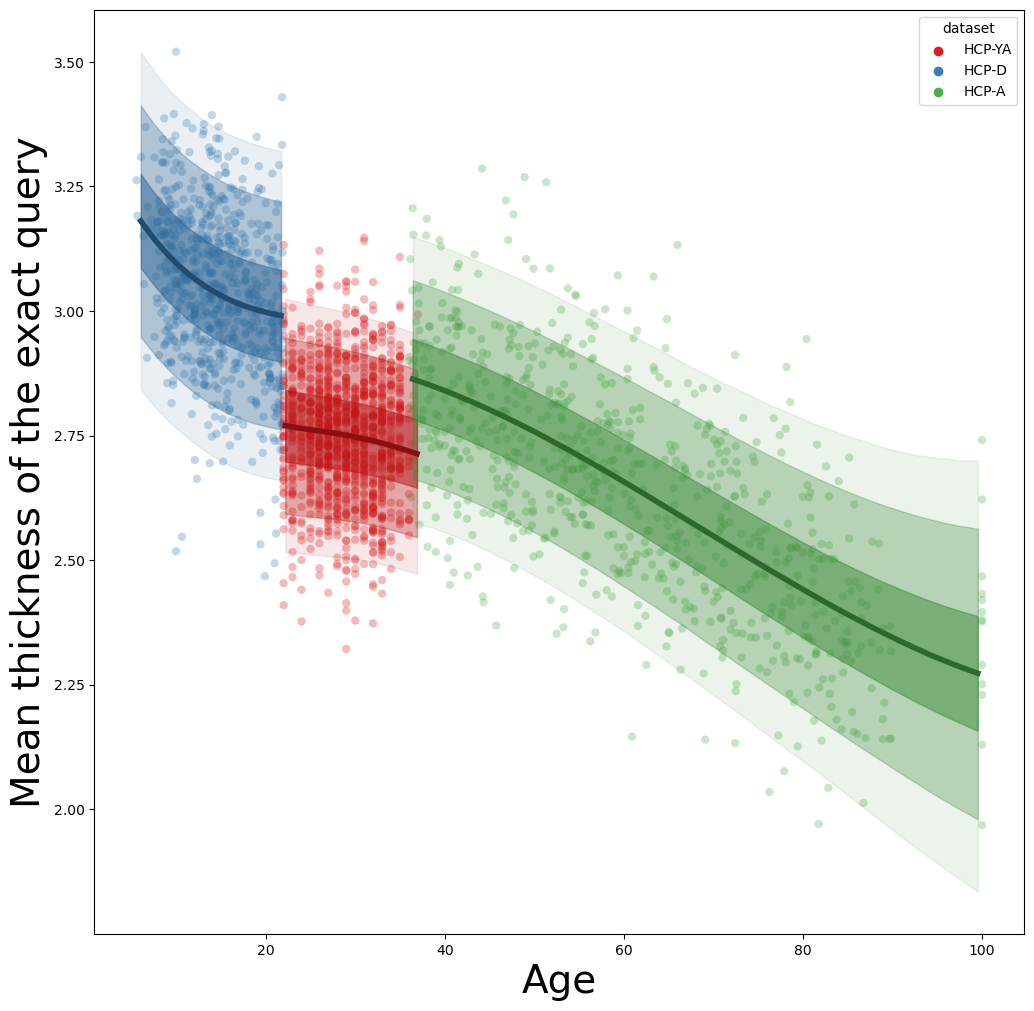

In [110]:
%%time

sigmoid = lambda x: 1/(1 + np.exp(-x))

# A more detialed method evaluating aleatoric and "epistemic" uncertainty observed in the complete model posterior.

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

demography_df['query_thickness'] = query_thickness_vector.dot(all_thickness_data.T)

sns.scatterplot(
    data=demography_df,
    x='age',
    y='query_thickness',
    ax=ax,
    linewidth=0,
    hue='dataset',
    palette="Set1",
#     palette=mpl.cm.Set1,
    alpha = 0.3,
#     color=[0.3,0.6,0.9,0.5],
)

# ax.set_xlim(20,40)
# ax.set_ylim(2.2,3)

ax.set_xlabel('Age', fontsize=28)
ax.set_ylabel('Mean thickness of the exact query', fontsize=28)

for idx in np.unique(site_idxs):
    xi = xr.DataArray(np.linspace(np.min(age), np.max(age), 200), dims=["obs_id"])
    selection = (xi > np.min(age[site_idxs == idx])) & (xi < np.max(age[site_idxs == idx]))
    # post = advi_model_idata.posterior
    
    prediction_B_spline_age = patsy.dmatrix(
        "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
        {"xi": ((xi - age.mean()) / age.std()), "knots": knot_list[1:-1]},
    )
    
    kernels_y_ppc_mu = (
        kernel_posteriors['intercept_sex'].isel(sex=0) +
        kernel_posteriors['intercept_site'].isel(site=idx) +
        xr.dot(
            xr.DataArray(np.asarray(prediction_B_spline_age), dims=["obs_id", "splines"]),
            kernel_posteriors['w_age']
        )
    ) * xr.DataArray(all_thickness_data_encoded.std(0), dims=["kernel"]) + xr.DataArray(all_thickness_data_encoded.mean(0), dims=["kernel"])
    y_ppc_mu = xr.DataArray(np.array(xr.dot(
        xr.DataArray(query_thickness_vector_encoded.reshape(-1), dims=["kernel"]),
        kernels_y_ppc_mu
    )), dims=['chain', 'draw', 'obs_id']).stack(sample=("chain", "draw"))
    
    rho_ppc_mean = 2 * sigmoid(
        rho_kernel_posterior_means['intercept_sex_rho'].isel(sex=0).data +
        rho_kernel_posterior_means['intercept_site_rho'].isel(site=idx).data +
        xr.DataArray(prediction_B_spline_age, dims=["obs_id", "splines"]).dot(
            rho_kernel_posterior_means['w_age_rho']
        )
    ) - 1

    kernels_y_ppc_sigma = (
        kernel_posteriors['error_sex'].isel(sex=0) +
        kernel_posteriors['error_site'].isel(site=idx) +
        xr.dot(
            xr.DataArray(np.asarray(prediction_B_spline_age), dims=["obs_id", "splines"]),
            kernel_posteriors['w_error_age']
        )
    ) * xr.DataArray(all_thickness_data_encoded.std(0), dims=["kernel"])
    y_ppc_sigma = np.zeros((200, 2000))
    encoded_sigma = np.multiply(query_thickness_vector_encoded.reshape(-1, 1, 1), np.array(kernels_y_ppc_sigma.stack(sample=("chain", "draw"))))
    for obs in range(200):
        sparse_correlations = sparse_filler.copy()
        sparse_correlations.data = rho_ppc_mean[i]
        sparse_correlations = (sparse_correlations + sparse_correlations.T)
        sparse_correlations.setdiag(1)
        sparse_correlations = sparse_correlations.tocsr()
        # dimensions: ('kernel', 'chain', 'draw', 'obs_id')
        encoded_sigma_sample = encoded_sigma[:, obs, :]
        y_ppc_sigma[obs] = np.power(np.multiply(sparse_correlations.dot(encoded_sigma_sample), encoded_sigma_sample).sum(0), 0.5)
        # y_ppc_sigma[obs] = np.multiply(correlations.dot(encoded_sigma_sample), encoded_sigma_sample).sum(0)
    y_ppc_sigma = xr.DataArray(y_ppc_sigma, dims=["obs_id", "sample"])

    # y_ppc_alpha = post['thickness_skewness'].stack(sample=("chain", "draw")).data
    
    # need to ensure the correctness
    quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]
    
    thickness_quantiles = {
        q: (
            (
                # y_ppc_mu_mean + stats.norm.ppf(q=q) * y_ppc_sigma_mean
                # y_ppc_mu.mean('sample') + stats.norm.ppf(q=q) * y_ppc_sigma.mean("sample")
                np.quantile(((y_ppc_mu + stats.norm.ppf(q=q) * y_ppc_sigma)), q, 1)
            )
            # * thickness_std +
            # thickness_mean
        ) for q in quantiles
    }

    # centile plot
    for q1, q2, alpha in [(0.01, 0.99, 0.1), (0.05, 0.95, 0.3), (0.25, 0.75, 0.5)]:
        ax.fill_between(
            xi[selection],
            thickness_quantiles[q1][selection],
            thickness_quantiles[q2][selection],
            alpha=alpha,
            color=np.array(mpl.cm.Set1(idx)[:3])*0.8,
        )
    
    ax.plot(
        xi[selection],
        thickness_quantiles[0.5][selection],
        c=np.array(mpl.cm.Set1(idx)[:3])*0.6,
        lw=4,
    )


#### Modelling arbitrary queries: left vs. right (males) 👈👉

---


In [111]:
# mean thickness vector representation
lr_query_thickness_vector = np.concatenate(
    [
        normalize(np.ones(left_cortical_surface_model.index_count).reshape(1,-1), norm='l1')[0],
        -normalize(np.ones(right_cortical_surface_model.index_count).reshape(1,-1), norm='l1')[0],
    ]
).reshape(-1)
lr_query_thickness_vector_encoded = np.dot(lr_query_thickness_vector.reshape(1,-1), css_kernel_eigenvectors)


In [112]:
ax = sns.lineplot(y=(lr_query_thickness_vector_encoded.ravel()**2)/(np.linalg.norm(lr_query_thickness_vector_encoded)), x=1+np.arange(lr_query_thickness_vector_encoded.shape[1]))
ax.set_xscale('log')
# ax.set_yscale('log')


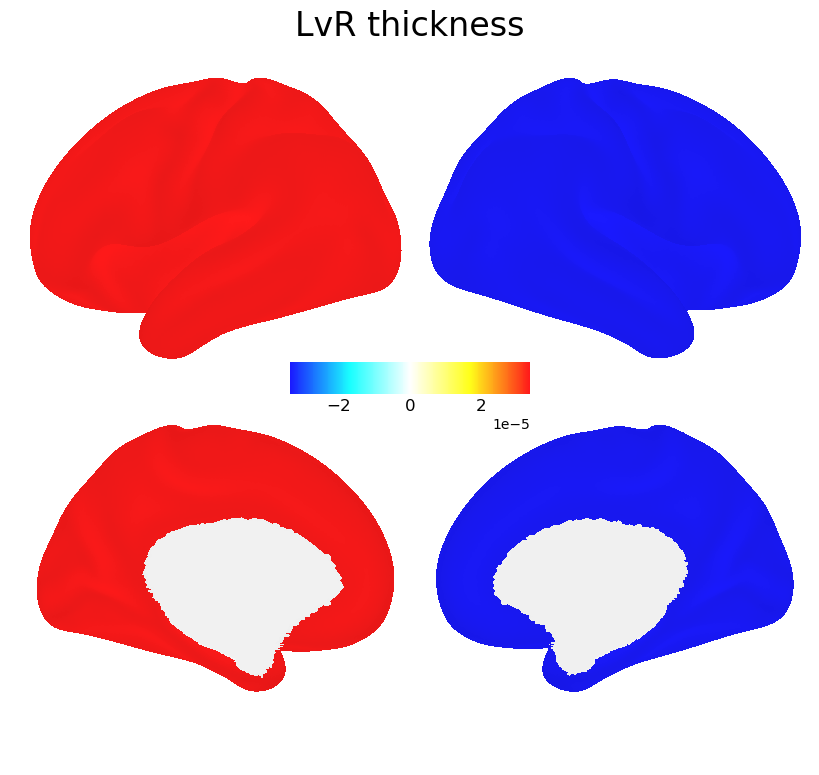

In [161]:
plot_data_on_brain_surface(
    lr_query_thickness_vector,
    # np.dot(lr_query_thickness_vector_encoded, css_kernel_eigenvectors.T)[0],
    title=f"LvR thickness",
    symmetric_cbar=True,
)


In [113]:
%%time

sigmoid = lambda x: 1/(1 + np.exp(-x))

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

demography_df['query_thickness'] = lr_query_thickness_vector.dot(all_thickness_data.T)

sns.scatterplot(
    data=demography_df,
    x='age',
    y='query_thickness',
    ax=ax,
    linewidth=0,
    hue='dataset',
    palette="Set1",
#     palette=mpl.cm.Set1,
    alpha = 0.3,
#     color=[0.3,0.6,0.9,0.5],
)

# ax.set_xlim(20,40)
# ax.set_ylim(2.2,3)

ax.set_xlabel('Age', fontsize=28)
ax.set_ylabel('Mean thickness', fontsize=28)

for idx in np.unique(site_idxs):
    xi = xr.DataArray(np.linspace(np.min(age), np.max(age), 200), dims=["obs_id"])
    selection = (xi > np.min(age[site_idxs == idx])) & (xi < np.max(age[site_idxs == idx]))
    # post = advi_model_idata.posterior
    
    prediction_B_spline_age = patsy.dmatrix(
        "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
        {"xi": ((xi - age.mean()) / age.std()), "knots": knot_list[1:-1]},
    )
    
    kernels_y_ppc_mu_mean = (
        kernel_posterior_means['intercept_sex'].isel(sex=0) +
        kernel_posterior_means['intercept_site'].isel(site=idx) +
        xr.dot(
            xr.DataArray(np.asarray(prediction_B_spline_age), dims=["obs_id", "splines"]),
            kernel_posterior_means['w_age']
        )
    ) * xr.DataArray(all_thickness_data_encoded.std(0), dims=["kernel"]) + xr.DataArray(all_thickness_data_encoded.mean(0), dims=["kernel"])
    y_ppc_mu_mean = np.array(xr.dot(
        xr.DataArray(lr_query_thickness_vector_encoded.reshape(-1), dims=["kernel"]),
        kernels_y_ppc_mu_mean
    ))
    
    rho_ppc_mean = 2 * sigmoid(
        rho_kernel_posterior_means['intercept_sex_rho'].isel(sex=0).data +
        rho_kernel_posterior_means['intercept_site_rho'].isel(site=idx).data +
        xr.DataArray(prediction_B_spline_age, dims=["obs_id", "splines"]).dot(
            rho_kernel_posterior_means['w_age_rho']
        )
    ) - 1

    kernels_y_ppc_sigma_mean = (
        kernel_posterior_means['error_sex'].isel(sex=0) +
        kernel_posterior_means['error_site'].isel(site=idx) +
        xr.dot(
            xr.DataArray(np.asarray(prediction_B_spline_age), dims=["obs_id", "splines"]),
            kernel_posterior_means['w_error_age']
        )
    ) * xr.DataArray(all_thickness_data_encoded.std(0), dims=["kernel"])
    y_ppc_sigma_mean = np.zeros(200)
    for i in range(200):
        sparse_correlations = sparse_filler.copy()
        sparse_correlations.data = rho_ppc_mean[i]
        sparse_correlations = (sparse_correlations + sparse_correlations.T)
        sparse_correlations.setdiag(1)
        sparse_correlations = sparse_correlations.tocsr()
        y_ppc_sigma_mean[i] = np.power(
            sparse_correlations.dot(
                np.multiply(
                    lr_query_thickness_vector_encoded.reshape(-1,),
                    np.array(kernels_y_ppc_sigma_mean).T[i]
                )
            ).dot(
                np.multiply(
                    lr_query_thickness_vector_encoded.reshape(-1,),
                    np.array(kernels_y_ppc_sigma_mean).T[i]
                ),
            ),
            0.5
        )

    # y_ppc_alpha = post['thickness_skewness'].stack(sample=("chain", "draw")).data
    
    # need to ensure the correctness
    quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]
    
    thickness_quantiles = {
        q: (
            (
                y_ppc_mu_mean + stats.norm.ppf(q=q) * y_ppc_sigma_mean
            )
            # * thickness_std +
            # thickness_mean
        ) for q in quantiles
    }

    # centile plot
    for q1, q2, alpha in [(0.01, 0.99, 0.1), (0.05, 0.95, 0.3), (0.25, 0.75, 0.5)]:
        ax.fill_between(
            xi[selection],
            thickness_quantiles[q1][selection],
            thickness_quantiles[q2][selection],
            alpha=alpha,
            color=np.array(mpl.cm.Set1(idx)[:3])*0.8,
        )
    
    ax.plot(
        xi[selection],
        thickness_quantiles[0.5][selection],
        c=np.array(mpl.cm.Set1(idx)[:3])*0.6,
        lw=4,
    )


/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


CPU times: user 18 s, sys: 1.12 s, total: 19.1 s
Wall time: 16.7 s


/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


CPU times: user 1min 53s, sys: 1min, total: 2min 54s
Wall time: 2min 51s


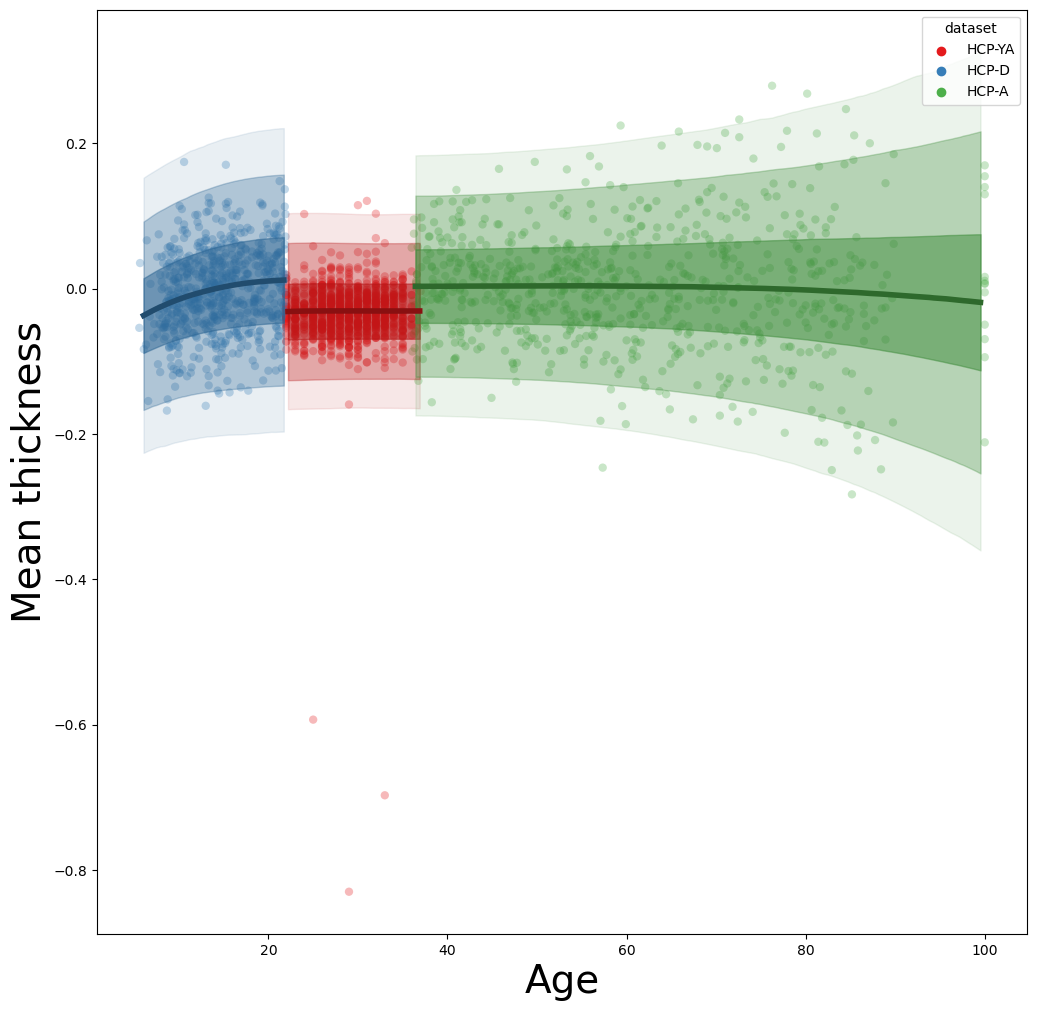

In [114]:
%%time

sigmoid = lambda x: 1/(1 + np.exp(-x))

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

demography_df['query_thickness'] = lr_query_thickness_vector.dot(all_thickness_data.T)

sns.scatterplot(
    data=demography_df,
    x='age',
    y='query_thickness',
    ax=ax,
    linewidth=0,
    hue='dataset',
    palette="Set1",
#     palette=mpl.cm.Set1,
    alpha = 0.3,
#     color=[0.3,0.6,0.9,0.5],
)

# ax.set_xlim(20,40)
# ax.set_ylim(2.2,3)

ax.set_xlabel('Age', fontsize=28)
ax.set_ylabel('Mean thickness', fontsize=28)

for idx in np.unique(site_idxs):
    xi = xr.DataArray(np.linspace(np.min(age), np.max(age), 200), dims=["obs_id"])
    selection = (xi > np.min(age[site_idxs == idx])) & (xi < np.max(age[site_idxs == idx]))
    # post = advi_model_idata.posterior
    
    prediction_B_spline_age = patsy.dmatrix(
        "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
        {"xi": ((xi - age.mean()) / age.std()), "knots": knot_list[1:-1]},
    )
    
    kernels_y_ppc_mu = (
        kernel_posteriors['intercept_sex'].isel(sex=0) +
        kernel_posteriors['intercept_site'].isel(site=idx) +
        xr.dot(
            xr.DataArray(np.asarray(prediction_B_spline_age), dims=["obs_id", "splines"]),
            kernel_posteriors['w_age']
        )
    ) * xr.DataArray(all_thickness_data_encoded.std(0), dims=["kernel"]) + xr.DataArray(all_thickness_data_encoded.mean(0), dims=["kernel"])
    y_ppc_mu = xr.DataArray(np.array(xr.dot(
        xr.DataArray(lr_query_thickness_vector_encoded.reshape(-1), dims=["kernel"]),
        kernels_y_ppc_mu
    )), dims=['chain', 'draw', 'obs_id']).stack(sample=("chain", "draw"))
    
    rho_ppc_mean = 2 * sigmoid(
        rho_kernel_posterior_means['intercept_sex_rho'].isel(sex=0).data +
        rho_kernel_posterior_means['intercept_site_rho'].isel(site=idx).data +
        xr.DataArray(prediction_B_spline_age, dims=["obs_id", "splines"]).dot(
            rho_kernel_posterior_means['w_age_rho']
        )
    ) - 1

    kernels_y_ppc_sigma = (
        kernel_posteriors['error_sex'].isel(sex=0) +
        kernel_posteriors['error_site'].isel(site=idx) +
        xr.dot(
            xr.DataArray(np.asarray(prediction_B_spline_age), dims=["obs_id", "splines"]),
            kernel_posteriors['w_error_age']
        )
    ) * xr.DataArray(all_thickness_data_encoded.std(0), dims=["kernel"])
    y_ppc_sigma = np.zeros((200, 2000))
    encoded_sigma = np.multiply(lr_query_thickness_vector_encoded.reshape(-1, 1, 1), np.array(kernels_y_ppc_sigma.stack(sample=("chain", "draw"))))
    for obs in range(200):
        sparse_correlations = sparse_filler.copy()
        sparse_correlations.data = rho_ppc_mean[i]
        sparse_correlations = (sparse_correlations + sparse_correlations.T)
        sparse_correlations.setdiag(1)
        sparse_correlations = sparse_correlations.tocsr()
        # dimensions: ('kernel', 'chain', 'draw', 'obs_id')
        encoded_sigma_sample = encoded_sigma[:, obs, :]
        y_ppc_sigma[obs] = np.power(np.multiply(sparse_correlations.dot(encoded_sigma_sample), encoded_sigma_sample).sum(0), 0.5)
        # y_ppc_sigma[obs] = np.multiply(correlations.dot(encoded_sigma_sample), encoded_sigma_sample).sum(0)
    y_ppc_sigma = xr.DataArray(y_ppc_sigma, dims=["obs_id", "sample"])

    # y_ppc_alpha = post['thickness_skewness'].stack(sample=("chain", "draw")).data
    
    # need to ensure the correctness
    quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]
    
    thickness_quantiles = {
        q: (
            (
                # y_ppc_mu_mean + stats.norm.ppf(q=q) * y_ppc_sigma_mean
                # y_ppc_mu.mean('sample') + stats.norm.ppf(q=q) * y_ppc_sigma.mean("sample")
                np.quantile(((y_ppc_mu + stats.norm.ppf(q=q) * y_ppc_sigma)), q, 1)
            )
            # * thickness_std +
            # thickness_mean
        ) for q in quantiles
    }

    # centile plot
    for q1, q2, alpha in [(0.01, 0.99, 0.1), (0.05, 0.95, 0.3), (0.25, 0.75, 0.5)]:
        ax.fill_between(
            xi[selection],
            thickness_quantiles[q1][selection],
            thickness_quantiles[q2][selection],
            alpha=alpha,
            color=np.array(mpl.cm.Set1(idx)[:3])*0.8,
        )
    
    ax.plot(
        xi[selection],
        thickness_quantiles[0.5][selection],
        c=np.array(mpl.cm.Set1(idx)[:3])*0.6,
        lw=4,
    )
